<a href="https://colab.research.google.com/github/Jillian-T/DPGM/blob/main/GP-EPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import scipy.io as scio

from tqdm.auto import tqdm
from dataclasses import dataclass
from torch.distributions import Gamma, Multinomial

c:\Users\j1487\miniconda3\envs\EPM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


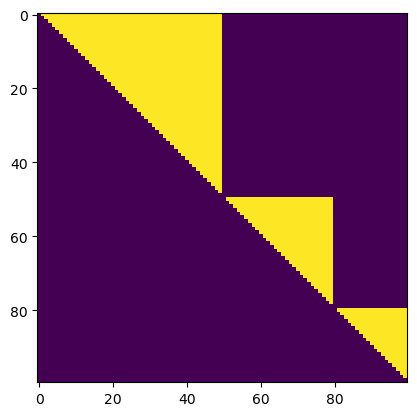

In [2]:
syn_data = torch.zeros(100, 100)

syn_data[:50, :50] = torch.ones(50, 50)
syn_data[50:80, 50:80] = torch.ones(30, 30)
syn_data[80:, 80:] = torch.ones(20, 20)

syn_data = torch.triu(syn_data, diagonal=1)
plt.imshow(syn_data)

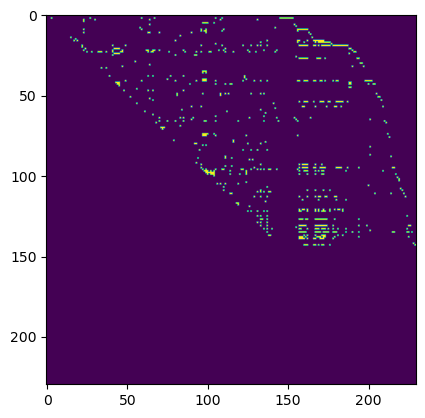

In [3]:
protein_data = scio.loadmat('./data/Protein230.mat')
protein_data = torch.from_numpy(protein_data['B'].todense())

plt.imshow(protein_data)

In [4]:
@dataclass
class ExperimentConfig:
    N: int
    K: int
    train_ratio: float
    burnin: int
    collection: int
    binary: bool

syn_config = ExperimentConfig(100, 100, 1., 1500, 1500, True)
protein_config = ExperimentConfig(230, 100, 1., 1500, 1500, True)

In [5]:
eps = 1e-32

def Po_plus(rate):
    r1 = rate[rate>=1]
    r2 = rate[rate<1]
    m = torch.zeros_like(rate)
    m1 = torch.zeros_like(r1)
    m2 = torch.zeros_like(r2)
    
    while True:
        dex = (m1 == 0).nonzero(as_tuple=True)
        if dex[0].numel() == 0:
            break
        else:
            r_dex = r1[dex]
            temp = torch.poisson(r_dex)
            idex = temp > 0
            m1[dex] = torch.where(idex, temp, m1[dex])
    m[rate>=1] = m1
    
    while True:
        dex = (m2 == 0).nonzero(as_tuple=True)
        if dex[0].numel() == 0:
            break
        else:
            r_dex = r2[dex]
            temp = 1 + torch.poisson(r_dex)
            idex = torch.rand_like(temp) < (1 / temp)
            m2[dex] = torch.where(idex, temp, m2[dex])
    m[rate<1] = m2
    
    return m

def multrnd_histc(n, p):
    edges = torch.cumsum(p, dim=0)
    edges = torch.nn.functional.pad(edges, pad=[1, 0], value=0)
    
    r = torch.histogram(
        torch.rand(n) * edges[-1],
        edges
    ).hist
    return r

def CRT(X, r):
    max_x = torch.max(X).int().item()
    
    rate = torch.arange(max_x).expand(*r.size(), -1) + r.unsqueeze(-1)
    rate = r.unsqueeze(-1) / rate                           # size = (N, max_x)
    rate = torch.repeat_interleave(rate.unsqueeze(0), len(X), dim=0)     # size = (K, N, max_x)
    
    bers = torch.bernoulli(rate)
    range_ = torch.arange(max_x).expand(*X.size(), -1)
    mask = range_ < X.unsqueeze(-1)
    bers = bers * mask.to(torch.int)
    bers = bers.sum(dim = -1)       # size = (K, N)
    return bers

In [6]:
class GP_EPM:
    def __init__(self, config: ExperimentConfig):
        self.N = config.N
        self.K = config.K
        self.binary = config.binary
        
        self.phi = Gamma(torch.ones(self.N, self.K), torch.ones(1)).sample()
        self.c_0 = 1
        self.c_i = torch.ones(self.N)
        self.a_i = torch.ones(self.N) / self.N
        self.e_0 = 1
        self.f_0 = 1e-2
        self.gamma_0 = 1
        self.r = torch.ones(self.K) / self.K
        
    def do_inference(self, m_idx, n_idx, X):
        
        # Draw latent
        if self.binary:
            latent_rate = (self.phi[m_idx, :] * self.phi[n_idx, :]) @ self.r  # size = (num)
            M = Po_plus(latent_rate)                             # size = (num)
            
        # Sample x_ik
        x_ik = torch.zeros(self.K, self.N)
        for i, j, x in zip(m_idx, n_idx, X):
            pmf = self.phi[i] * self.phi[j] * self.r
            # x_ijk = multrnd_histc(x.to(torch.int), pmf)
            x_ijk = Multinomial(x.to(torch.int).item(), pmf).sample()
            x_ik[:, i] += x_ijk
            x_ik[:, j] += x_ijk
        # self.mi_dot_k = mi_dot_k
        
        # Sample a_i
        phir = self.phi @ torch.diag(self.r)
        ell = CRT(x_ik, self.a_i).sum(dim=0)
        omega_ik = phir.sum(dim=0) - phir
        p_ik = omega_ik / (self.c_i.unsqueeze(-1) + omega_ik)
        a_i_alpha = self.e_0 + ell
        a_i_beta = self.f_0 - torch.log(torch.clamp_min(1 - p_ik, eps)).sum(dim=-1)
        self.a_i = Gamma(a_i_alpha, a_i_beta).sample()
        
        # Sample phi
        phi_alpha = self.a_i.unsqueeze(-1) + x_ik.T
        phi_beta = self.c_i.unsqueeze(-1) + omega_ik
        self.phi = Gamma(phi_alpha, phi_beta).sample()
        
        # Sample c_i
        c_i_alpha = 1 + self.K * self.a_i
        c_i_beta = 1 + self.phi.sum(dim=-1)
        self.c_i = Gamma(c_i_alpha, c_i_beta).sample()
        
        
        # Sample r
        temp = (self.phi * (self.phi.sum(dim=0) - self.phi)).sum(dim=0) * 0.5
        r_alpha = self.gamma_0 / self.K + 0.5 * torch.sum(x_ik, dim=-1)
        r_beta = self.c_0 + temp
        self.r = Gamma(r_alpha, r_beta).sample()
        
        # Sample gamma0
        ell = CRT(x_ik.sum(dim=-1, keepdim=True) / 2, torch.FloatTensor([self.gamma_0 / self.K])).sum(dim=0)
        gamma0_alpha = 1 + ell
        gamma0_beta = 1 - 1/self.K * torch.log(torch.clamp_min(self.c_0/(self.c_0+temp), eps)).sum()
        self.gamma_0 = Gamma(gamma0_alpha, gamma0_beta).sample()
        
        # Sample c_0
        c0_alpha = 1 + self.gamma_0
        c0_beta = 1 + self.r.sum()
        self.c_0 = Gamma(c0_alpha, c0_beta).sample()
        
        return x_ik

## Model Synthetic data

100%|██████████| 3000/3000 [1:19:00<00:00,  1.58s/it, K_plus=6, K_hard=5, gamma0=0.644] 


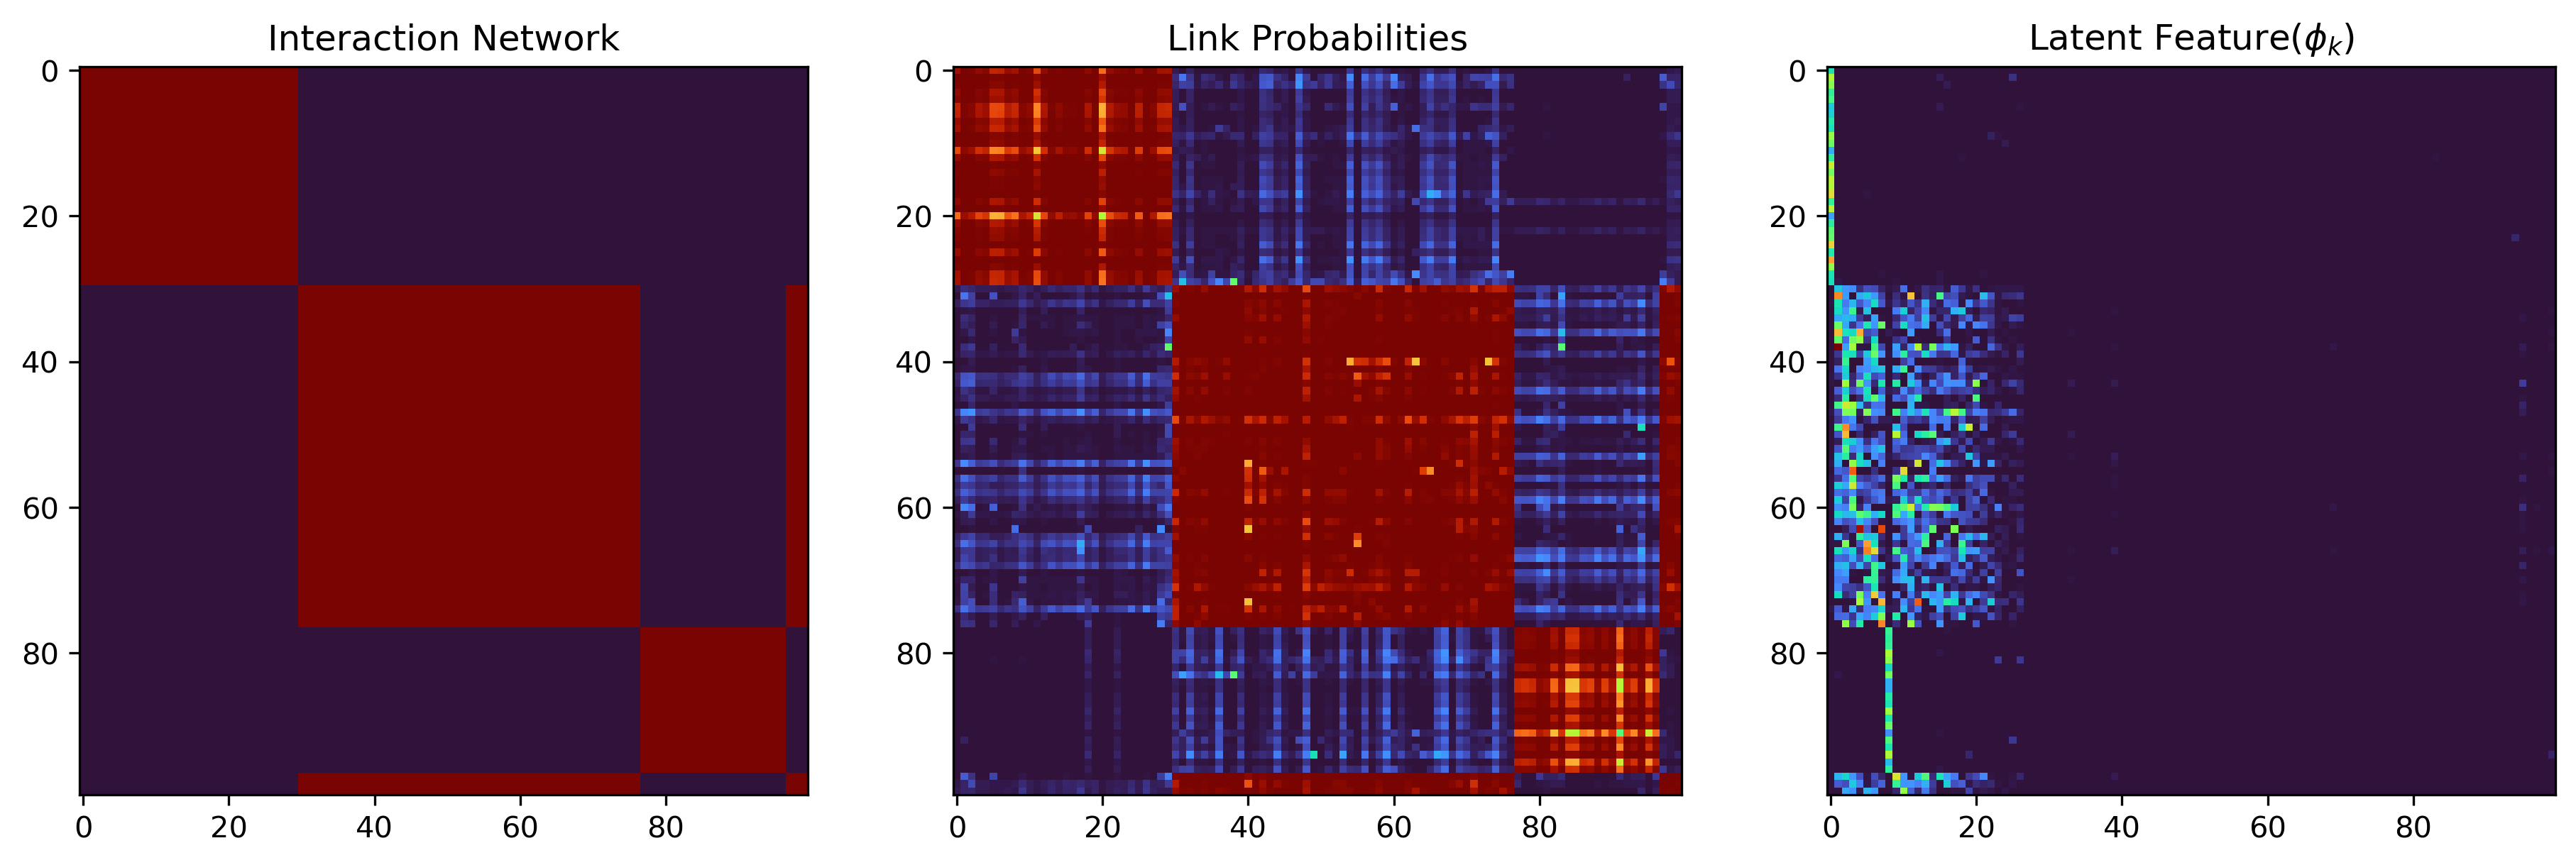

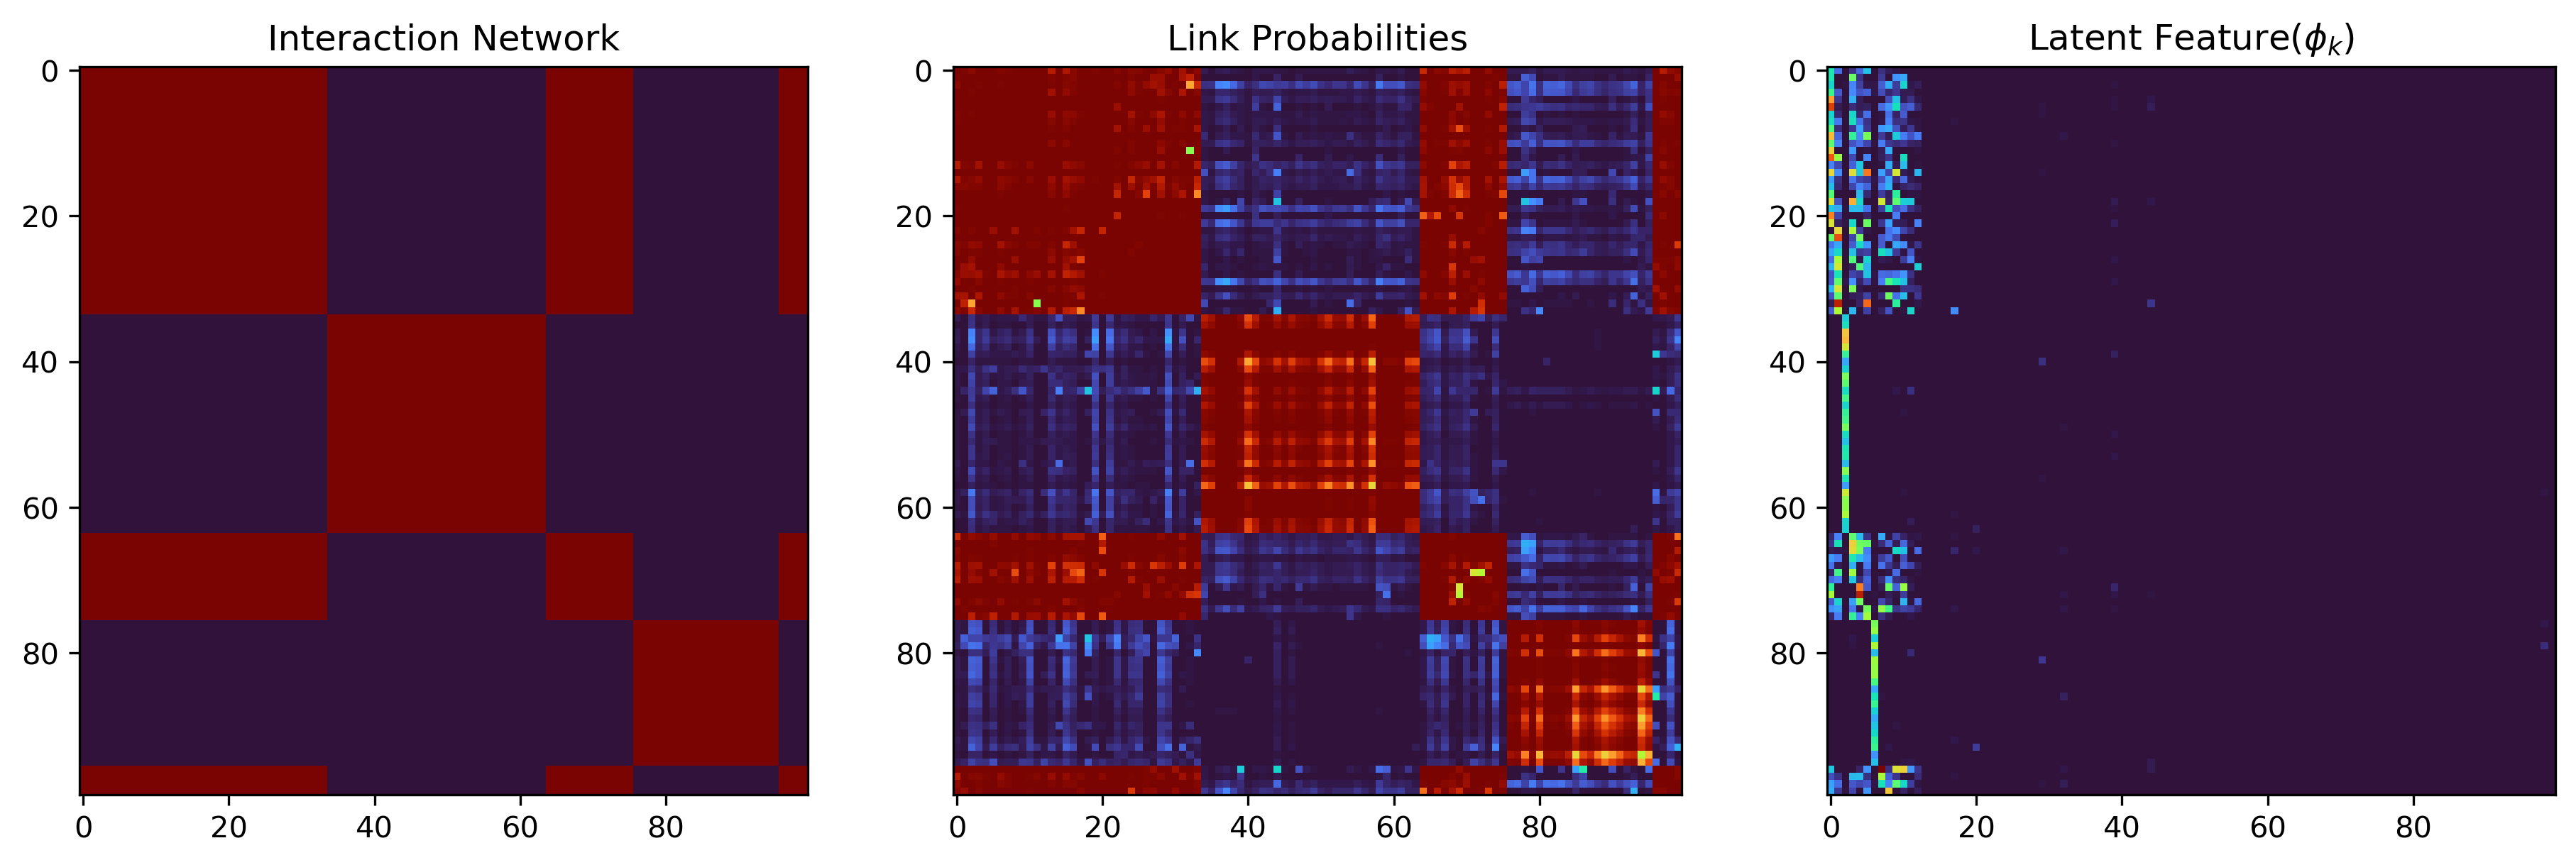

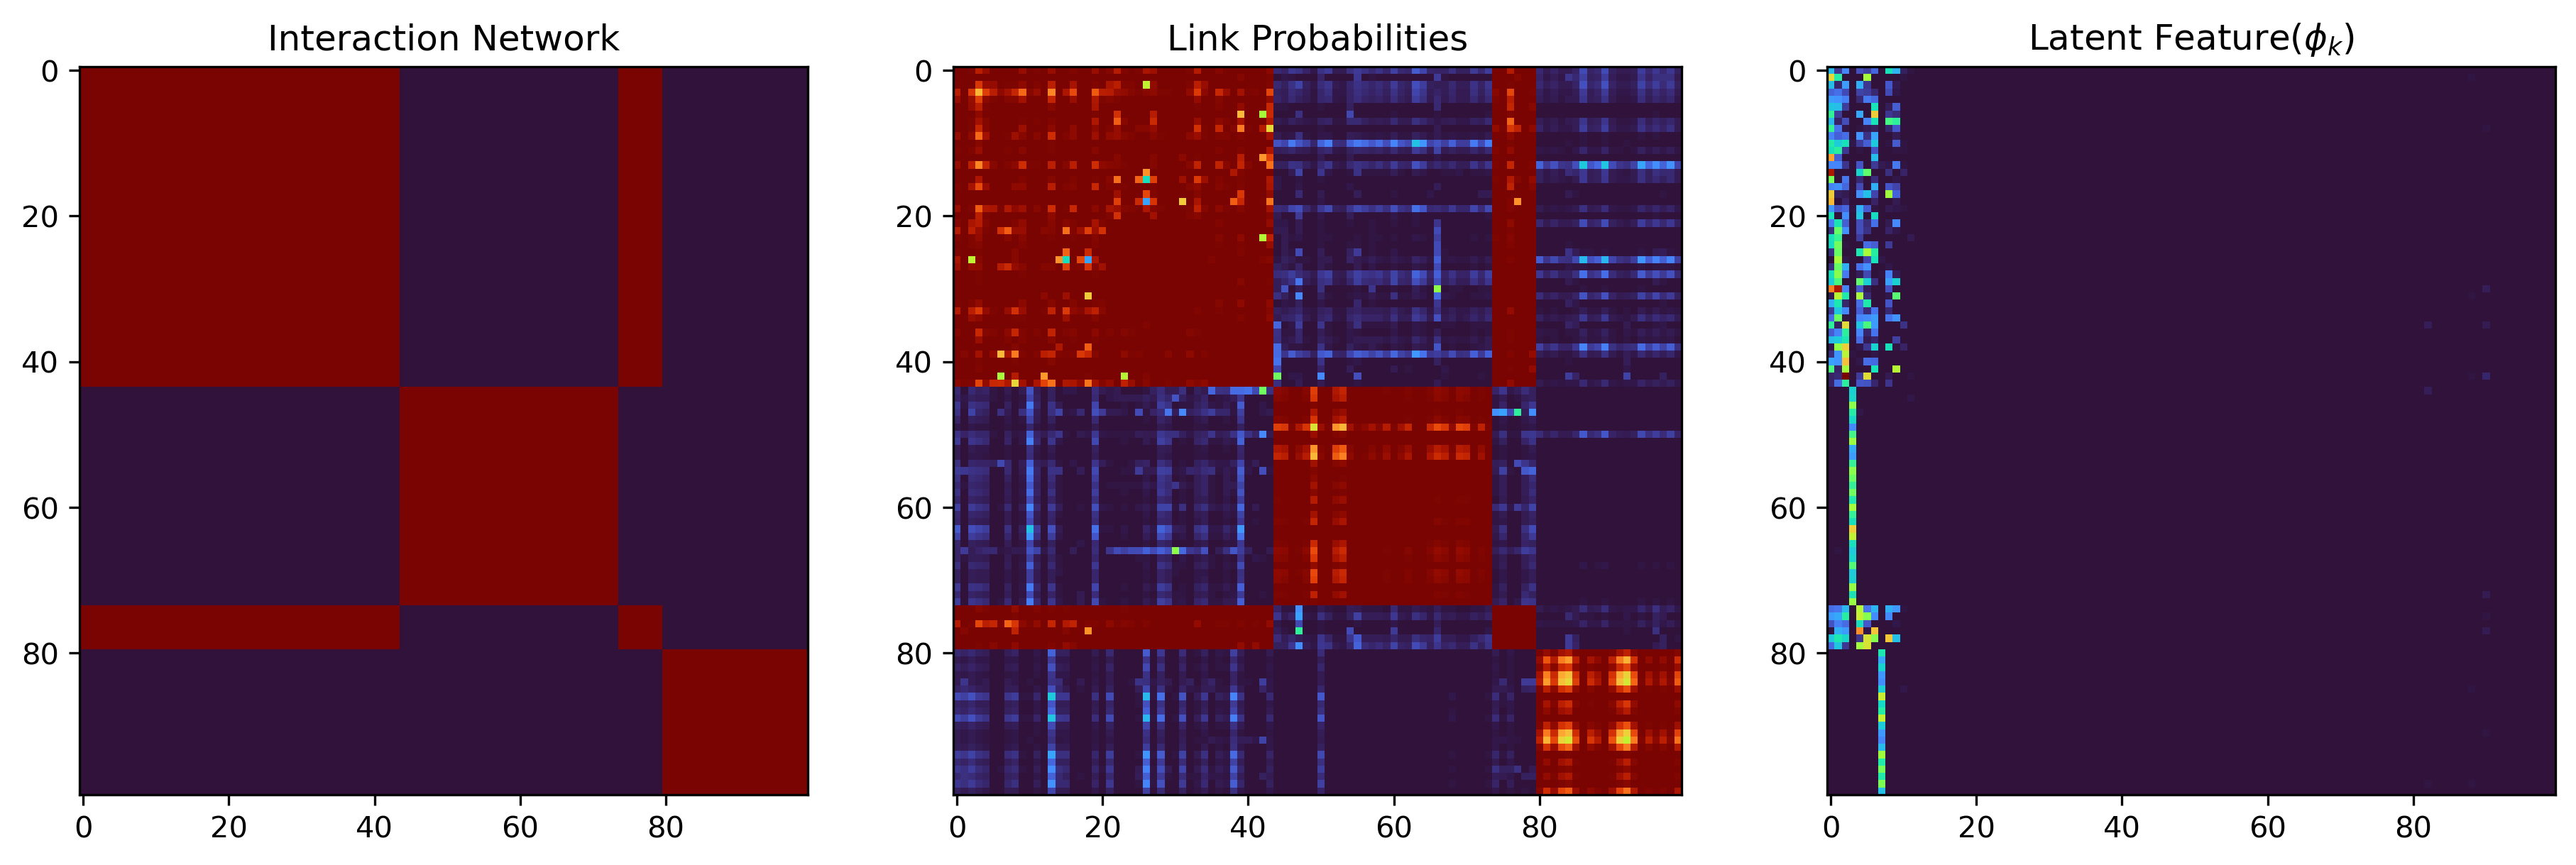

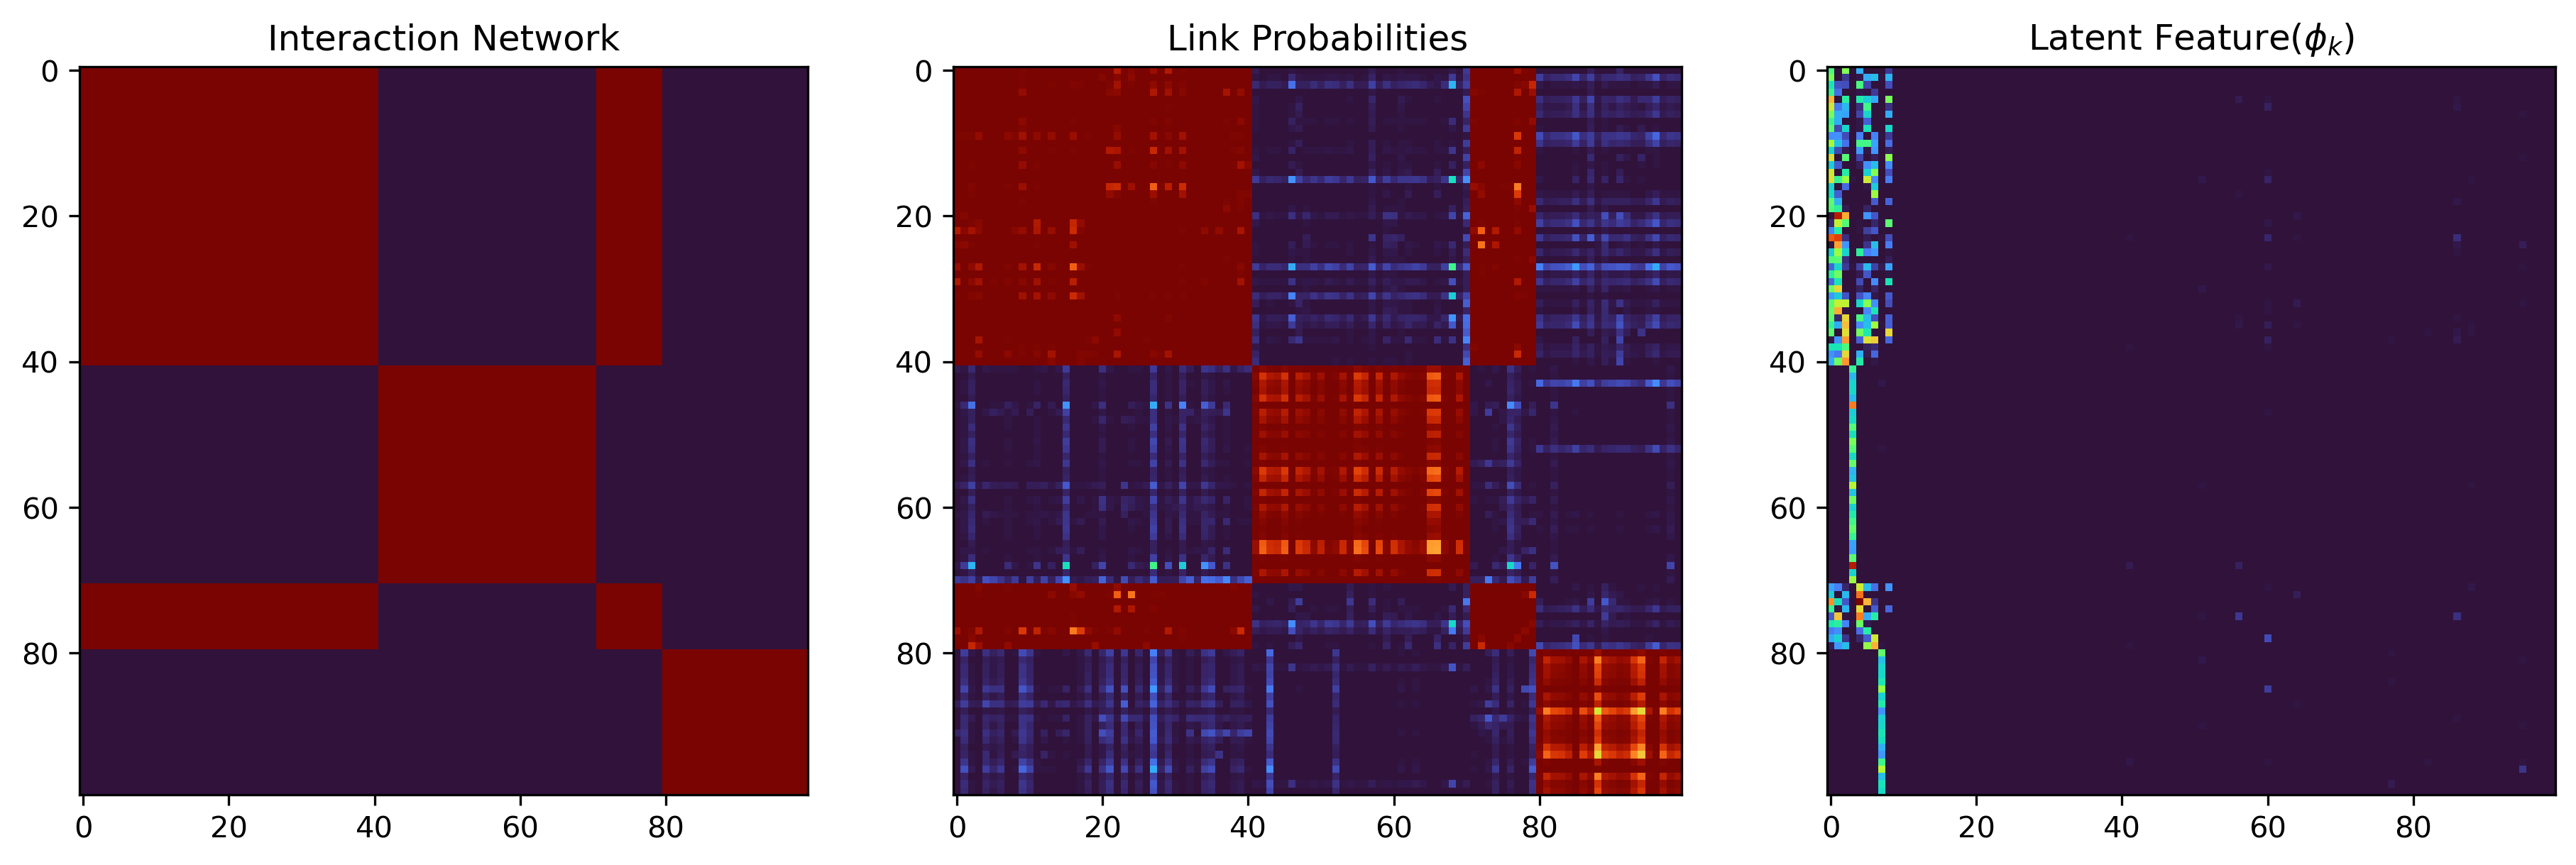

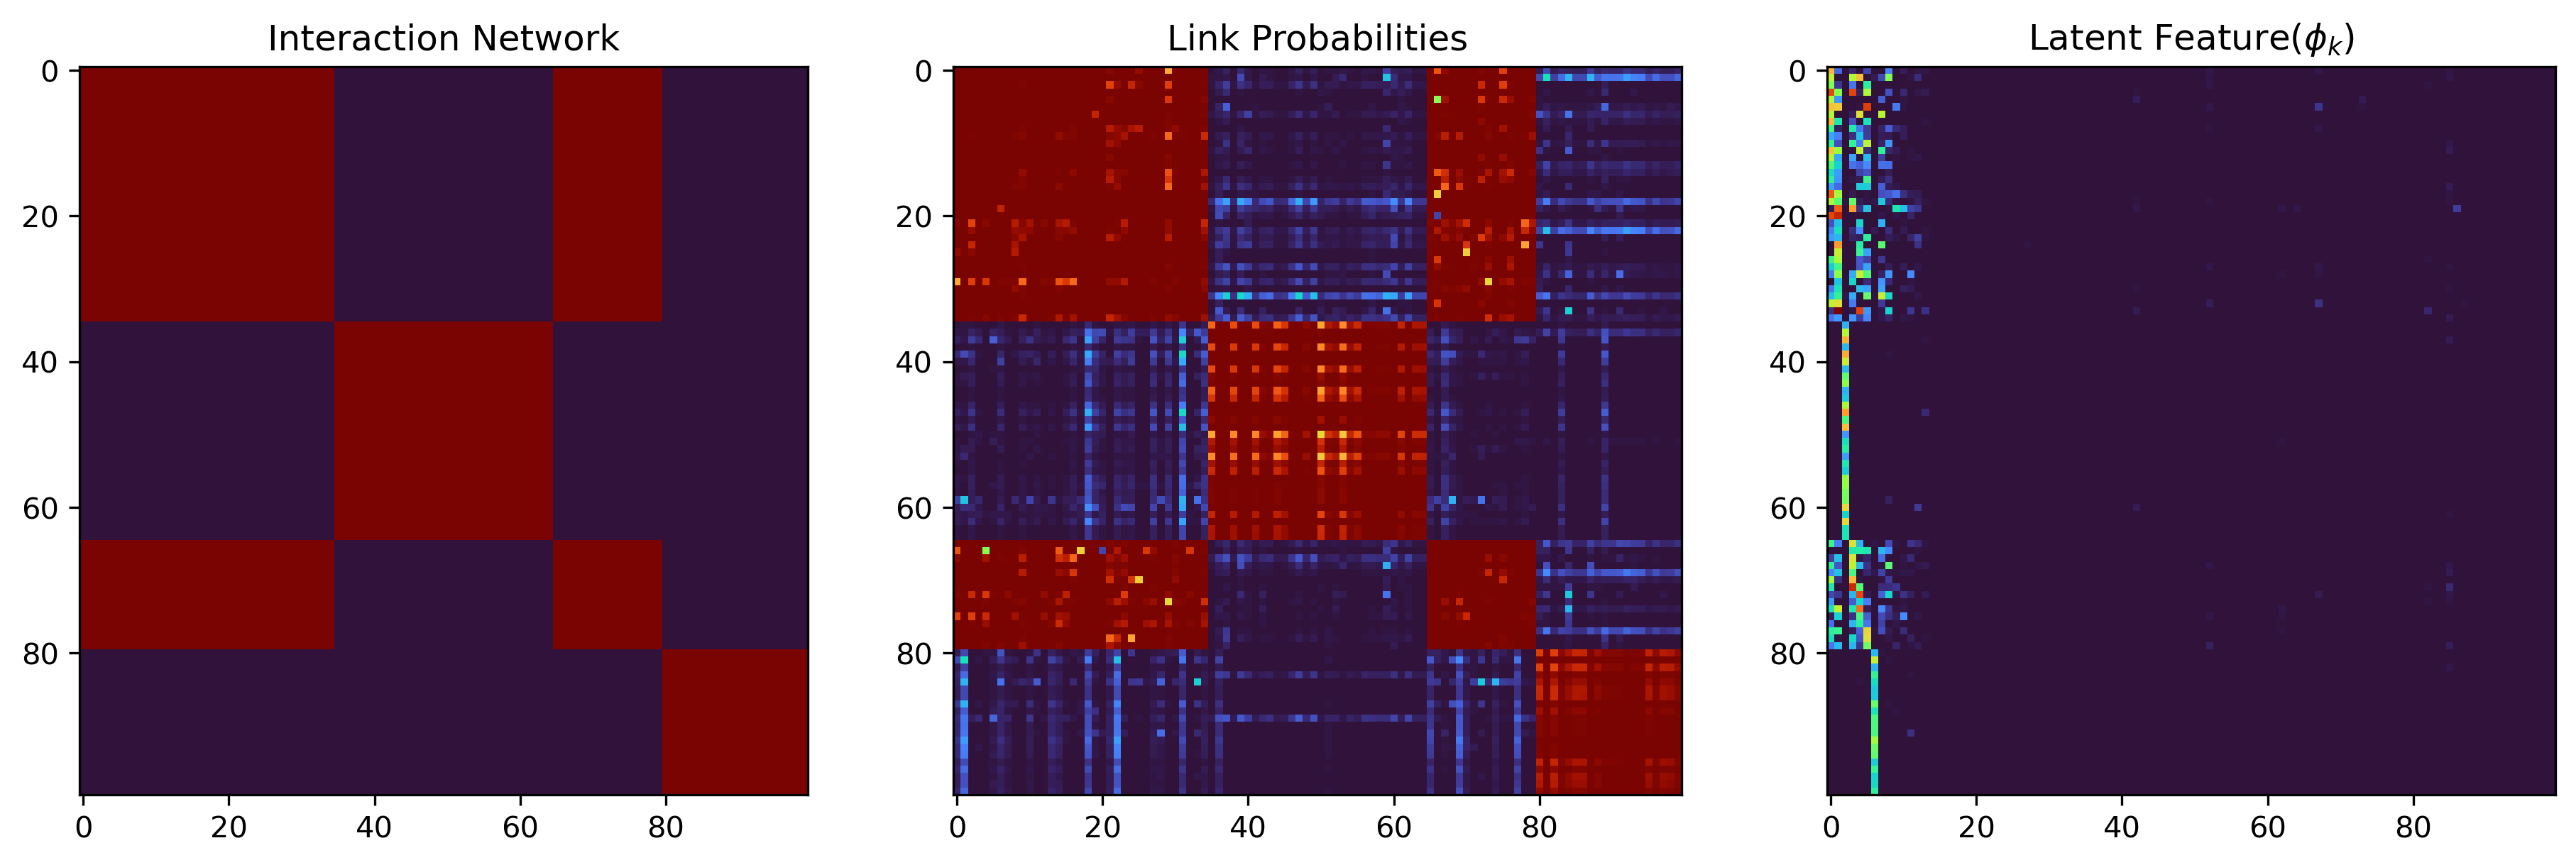

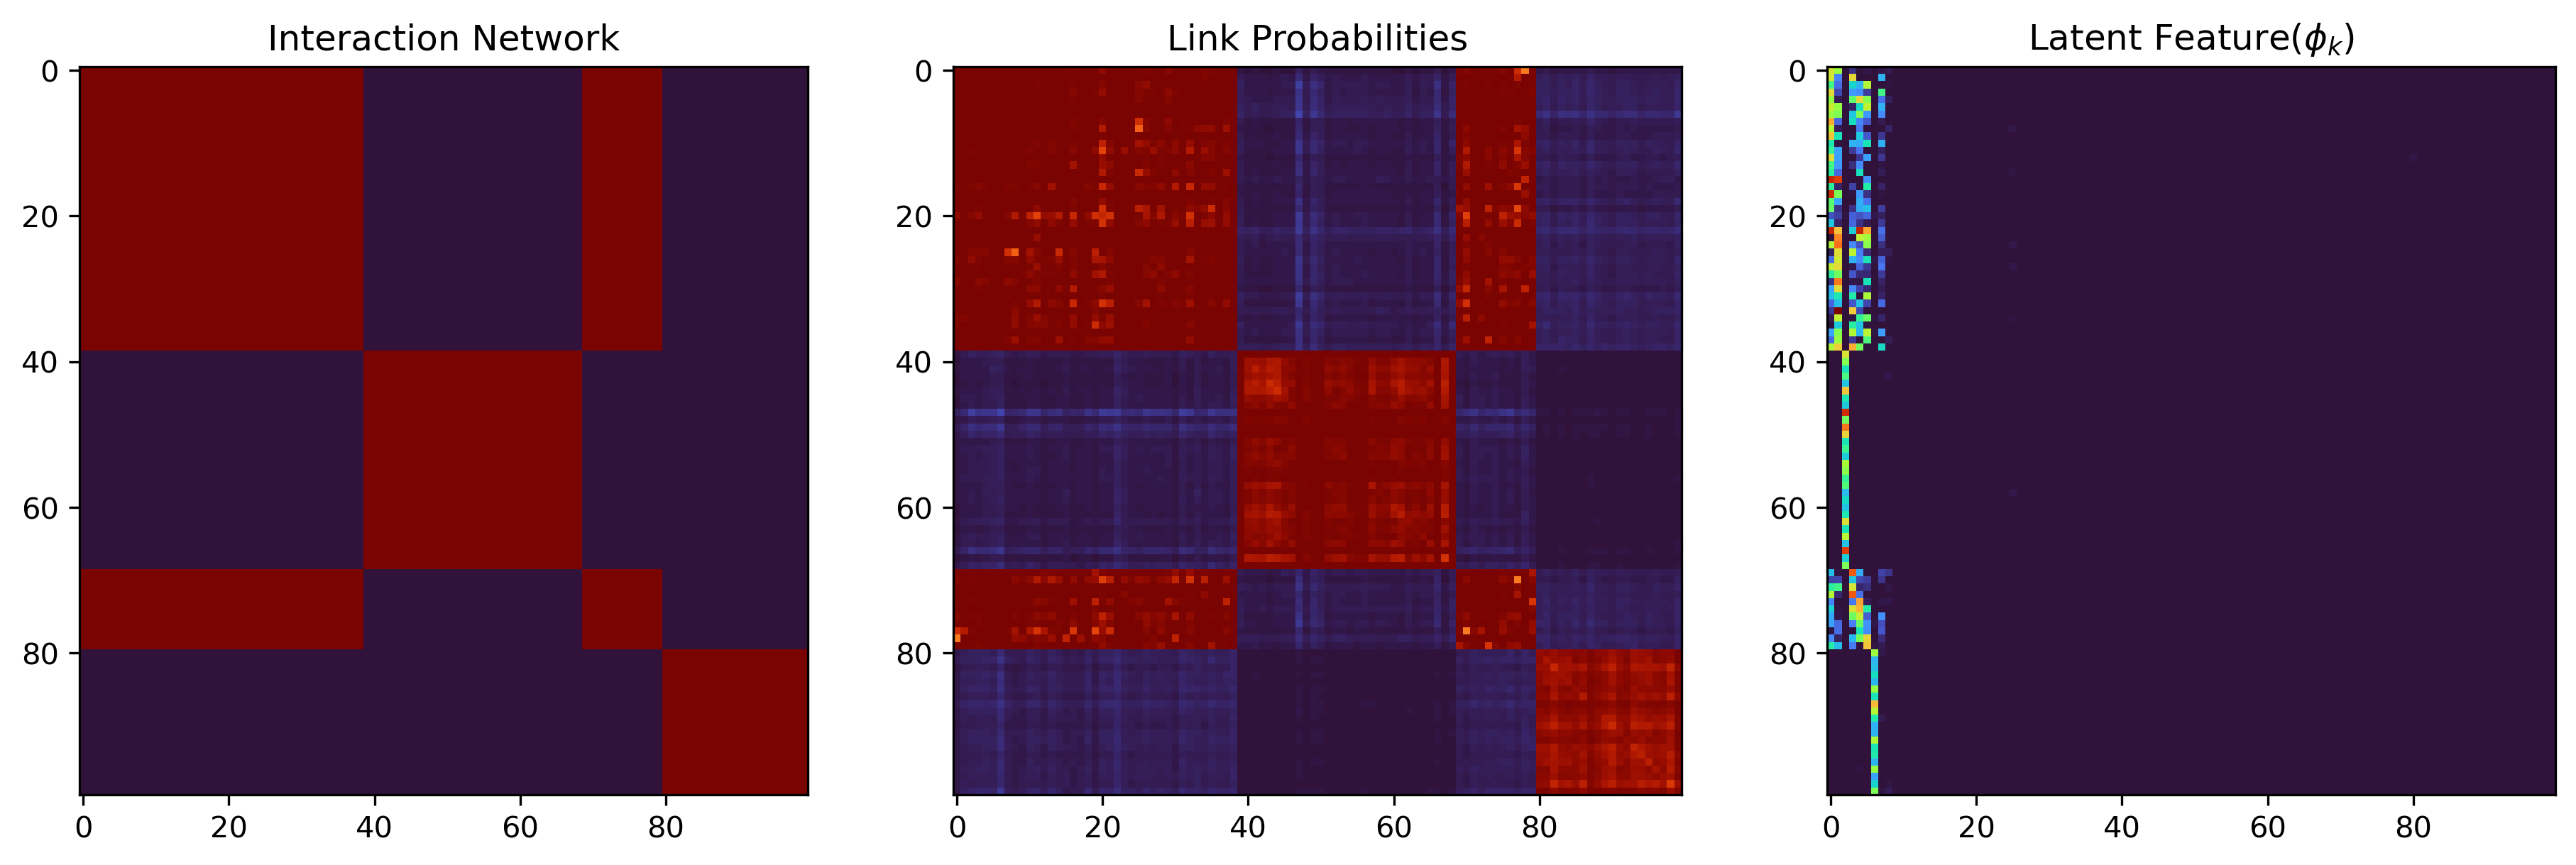

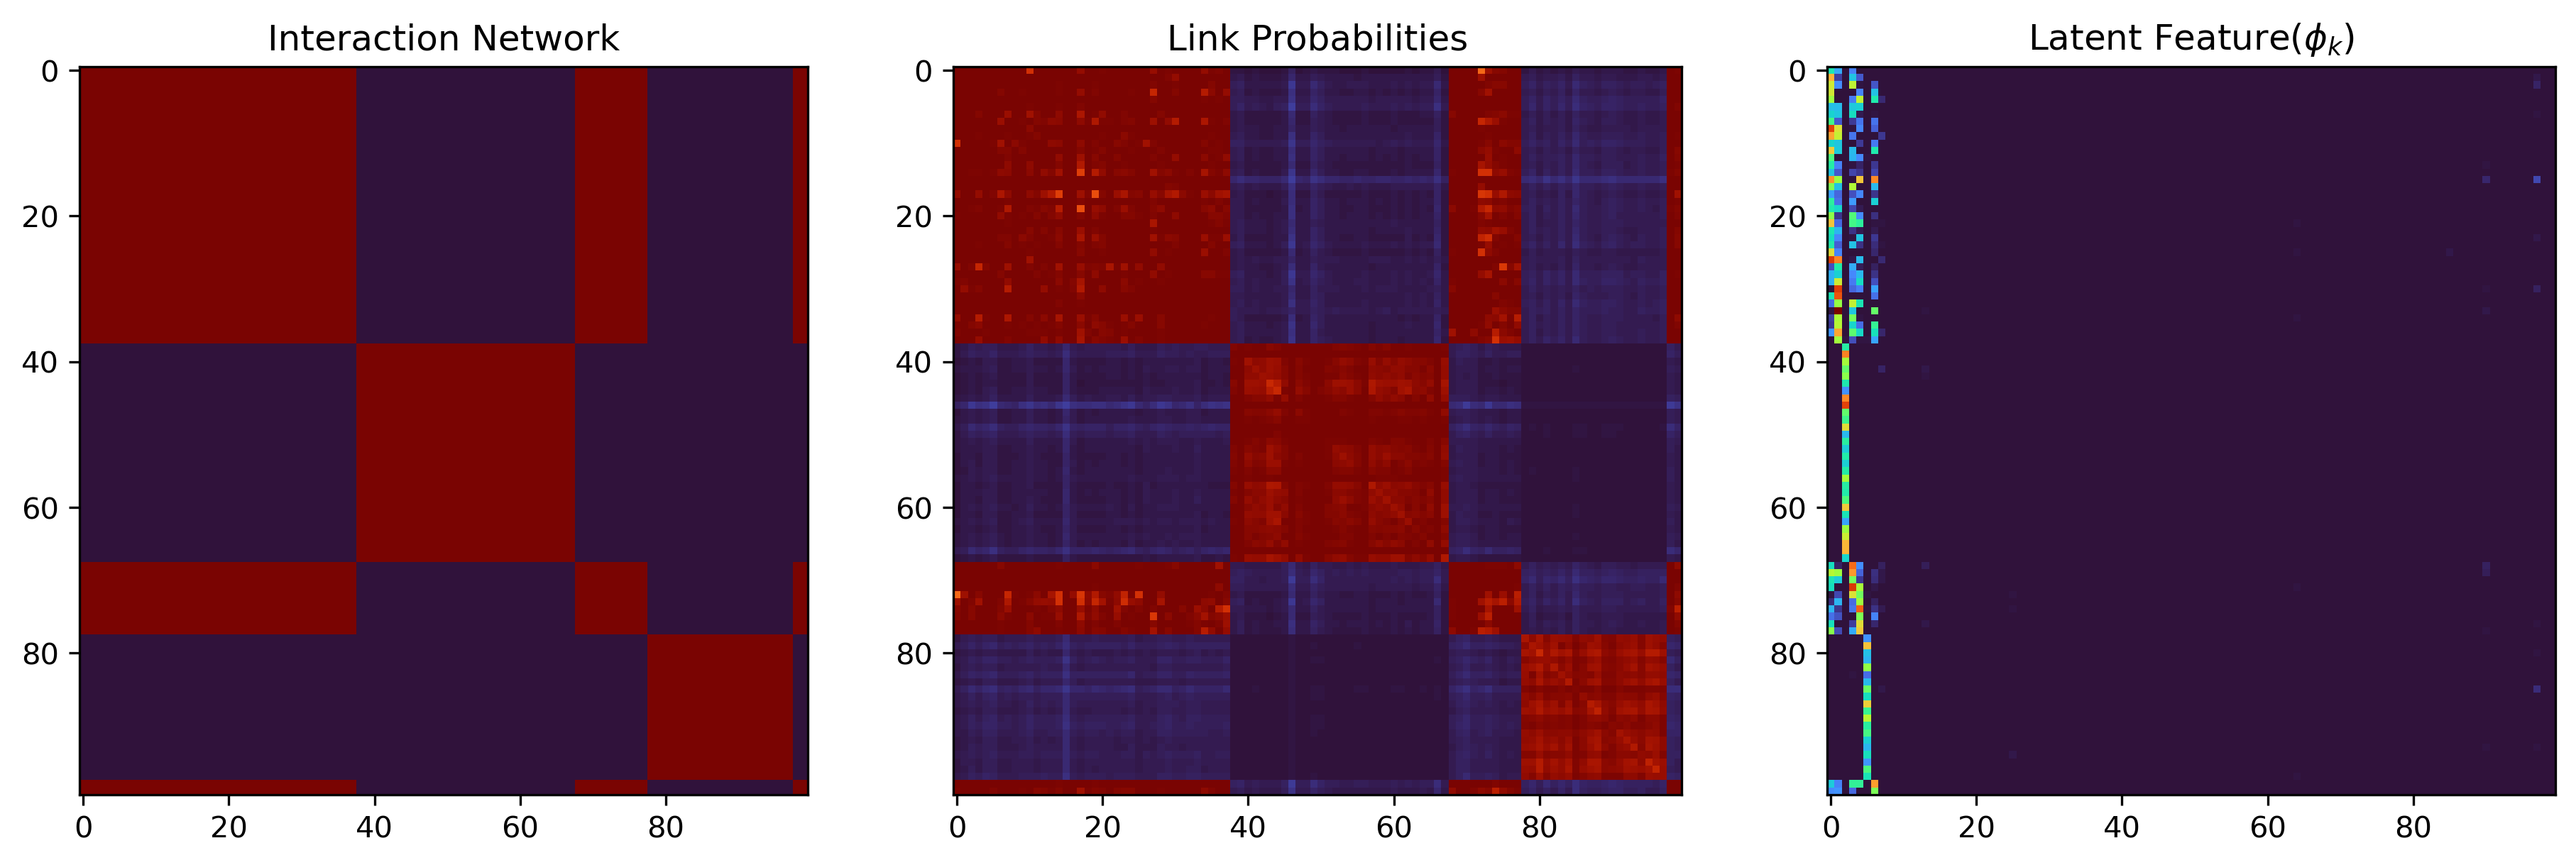

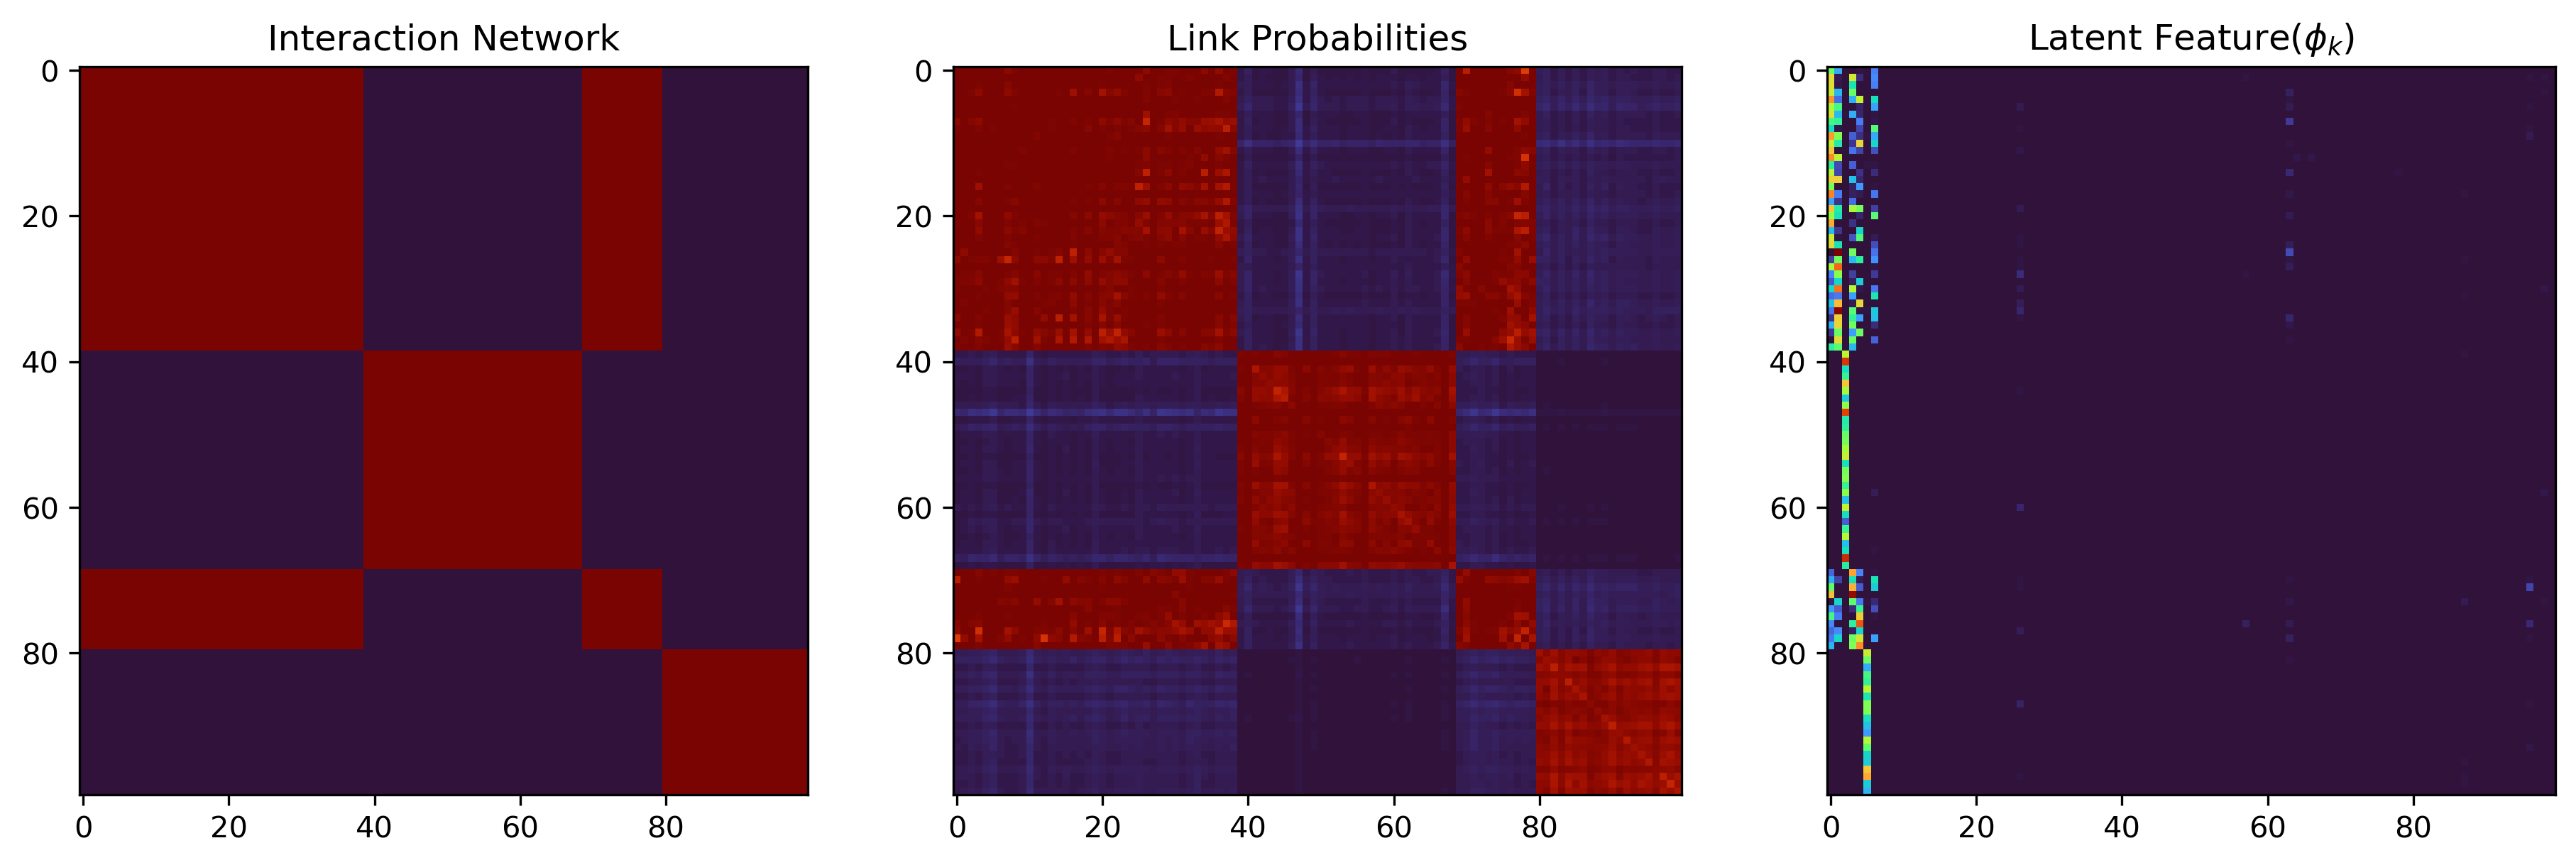

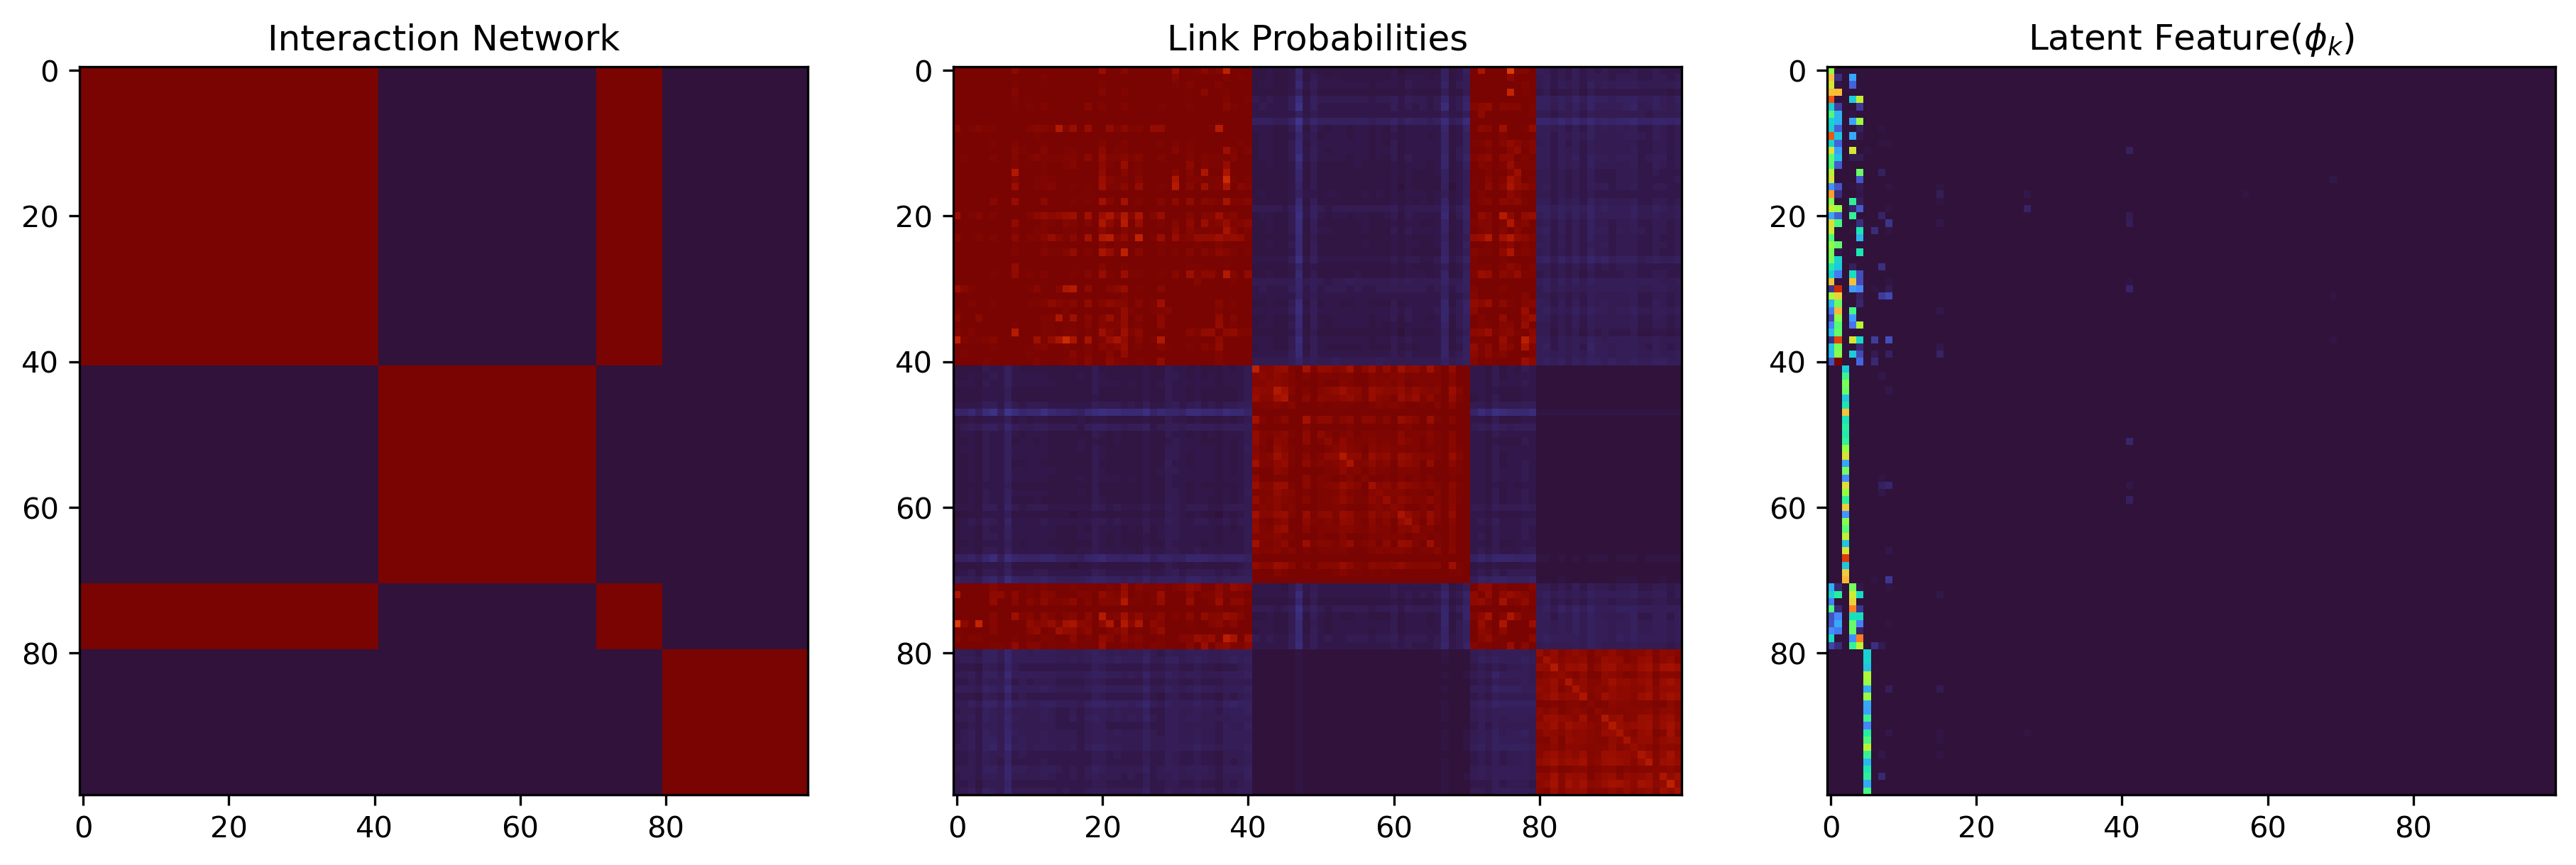

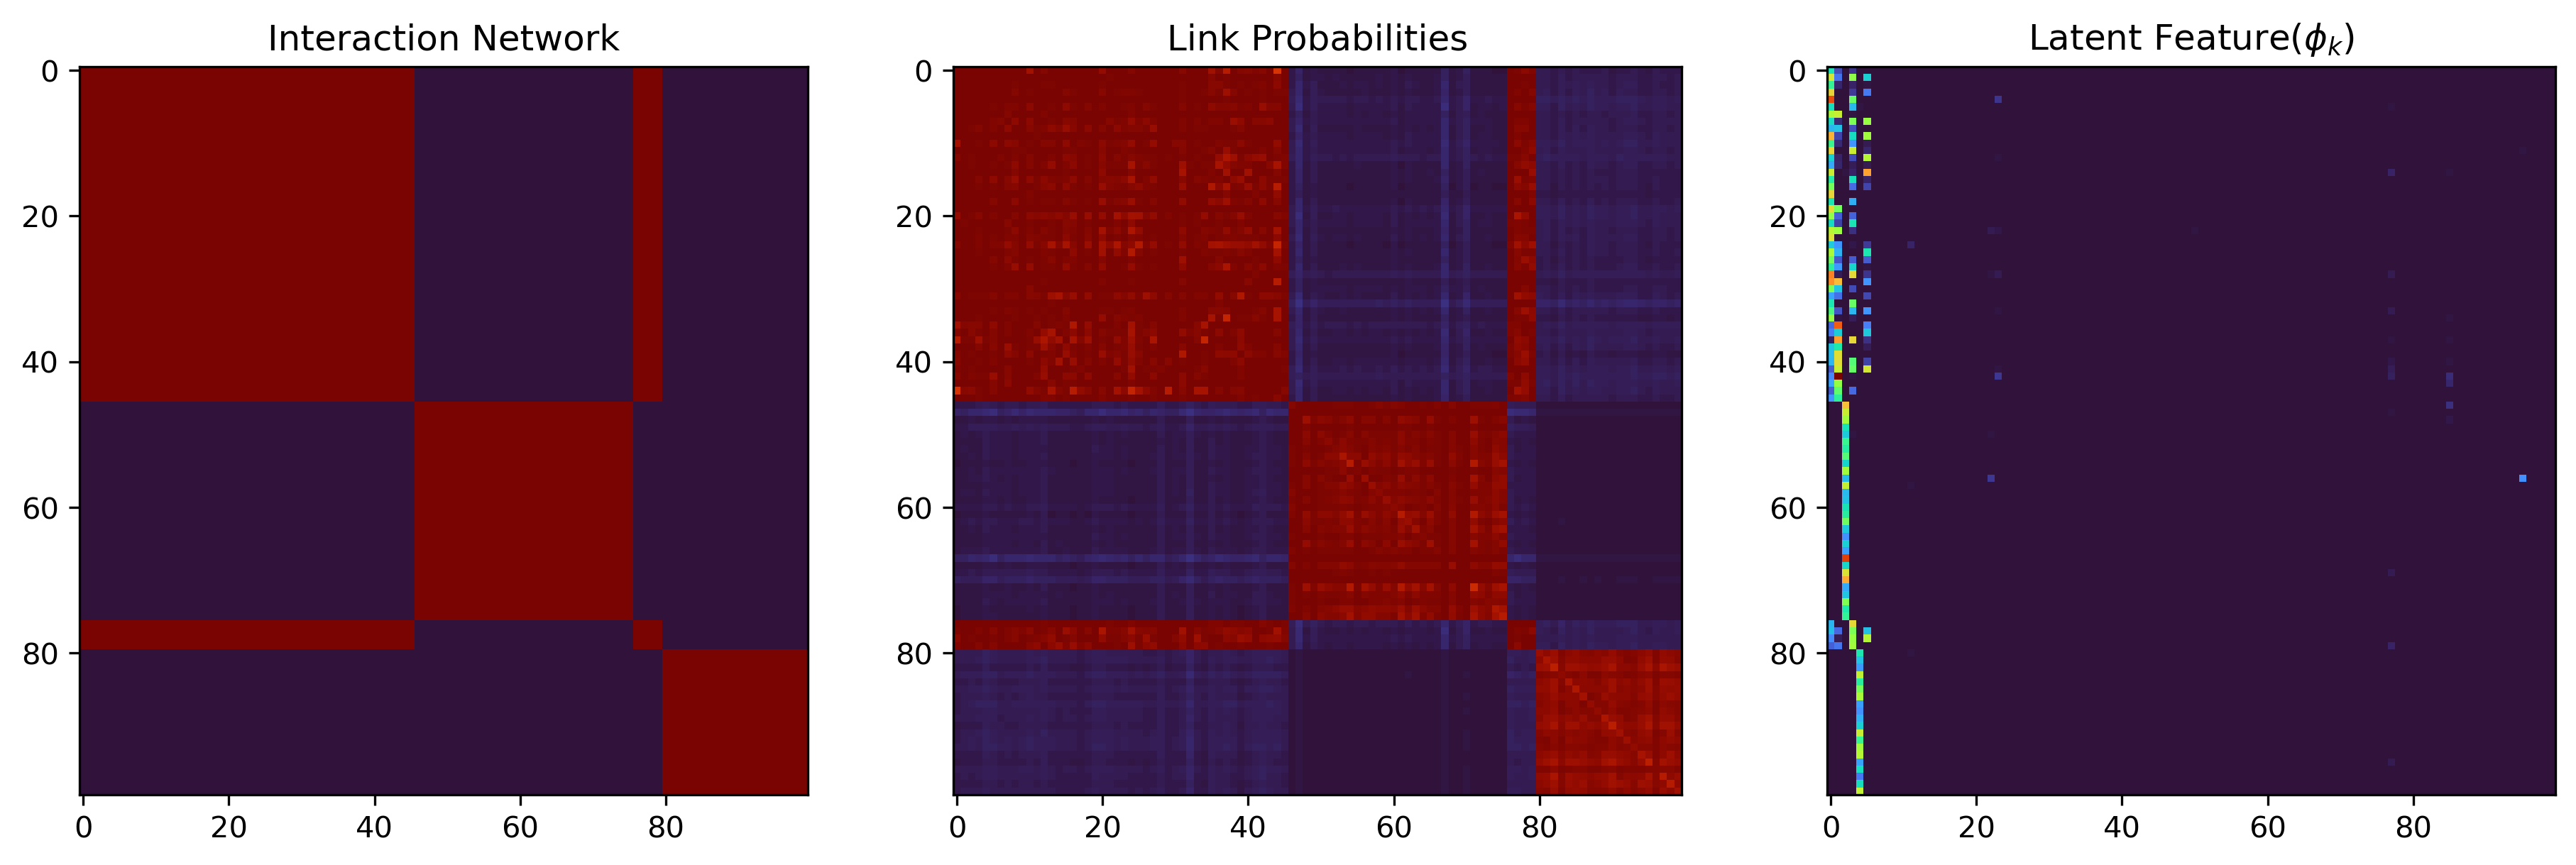

In [8]:
m_idx, n_idx = torch.nonzero(syn_data, as_tuple=True)
X = syn_data[m_idx, n_idx]
AA = syn_data + syn_data.T + torch.eye(len(syn_data))

model = GP_EPM(syn_config)
prob_sample = torch.zeros(syn_config.N, syn_config.N)

progress = tqdm(range(syn_config.burnin + syn_config.collection))
for i in progress:
    x_ik = model.do_inference(m_idx, n_idx, X)
    
    K_positive = len(torch.sum(x_ik, dim=-1).nonzero())
    
    prob = model.phi @ torch.diag(model.r) @ model.phi.T + eps
    prob = 1 - torch.exp(- prob)
    if i > syn_config.burnin:
        prob_sample = prob_sample + prob
        prob_ave = prob_sample / (i - syn_config.burnin)
    else:
        prob_ave = prob
        
    _, rdex = torch.sort(
        torch.sum(x_ik, dim=-1),
        descending=True
    )
    _, z = torch.max(x_ik[rdex], dim=0)
    _, Rank_dex = torch.sort(z)
    
    K_hardassignment = len(torch.unique(z))
    
    latent_feature = model.phi[Rank_dex][:, rdex] @ (torch.diag(model.r[rdex]) ** 0.5)
    latent_feature = torch.log(latent_feature + 9.99e-1)
    
    if (i+1)%300 == 0:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
        axs[0].set_title('Interaction Network')
        axs[0].imshow(AA[Rank_dex][:, Rank_dex])

        axs[1].set_title('Link Probabilities')
        axs[1].imshow(prob_ave[Rank_dex][:, Rank_dex], cmap='turbo')

        axs[2].set_title(r'Latent Feature($\phi_k$)')
        axs[2].imshow(latent_feature, cmap='turbo')
        
    progress.set_postfix({'K_plus': K_positive, 'K_hard': K_hardassignment, 'gamma0': model.gamma_0.item()})

## Model Protein Network

100%|██████████| 3000/3000 [20:17<00:00,  2.46it/s, K_plus=3, K_hard=2, gamma0=0.126]  


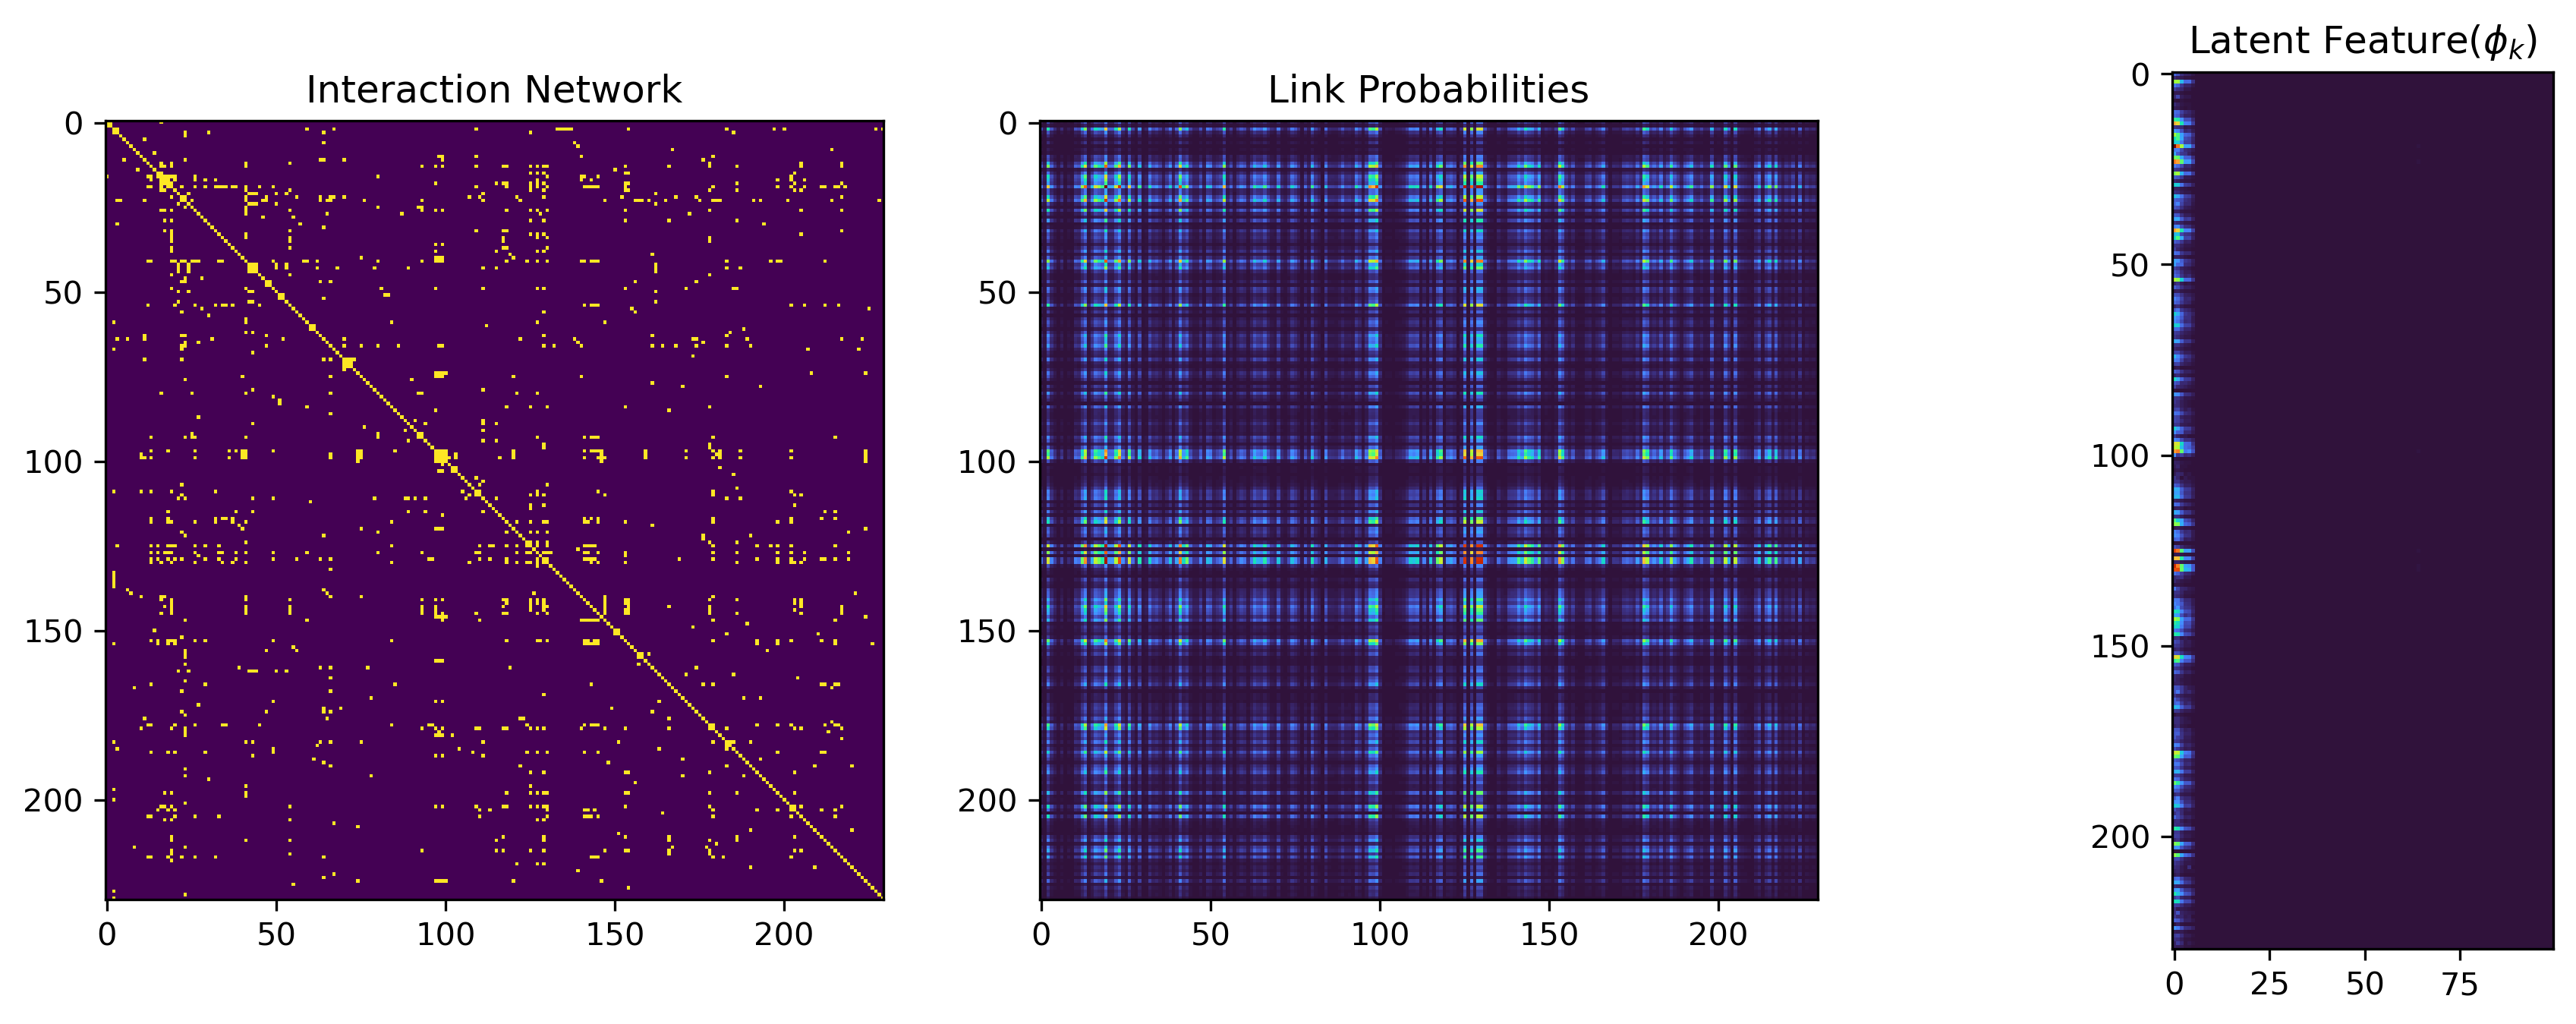

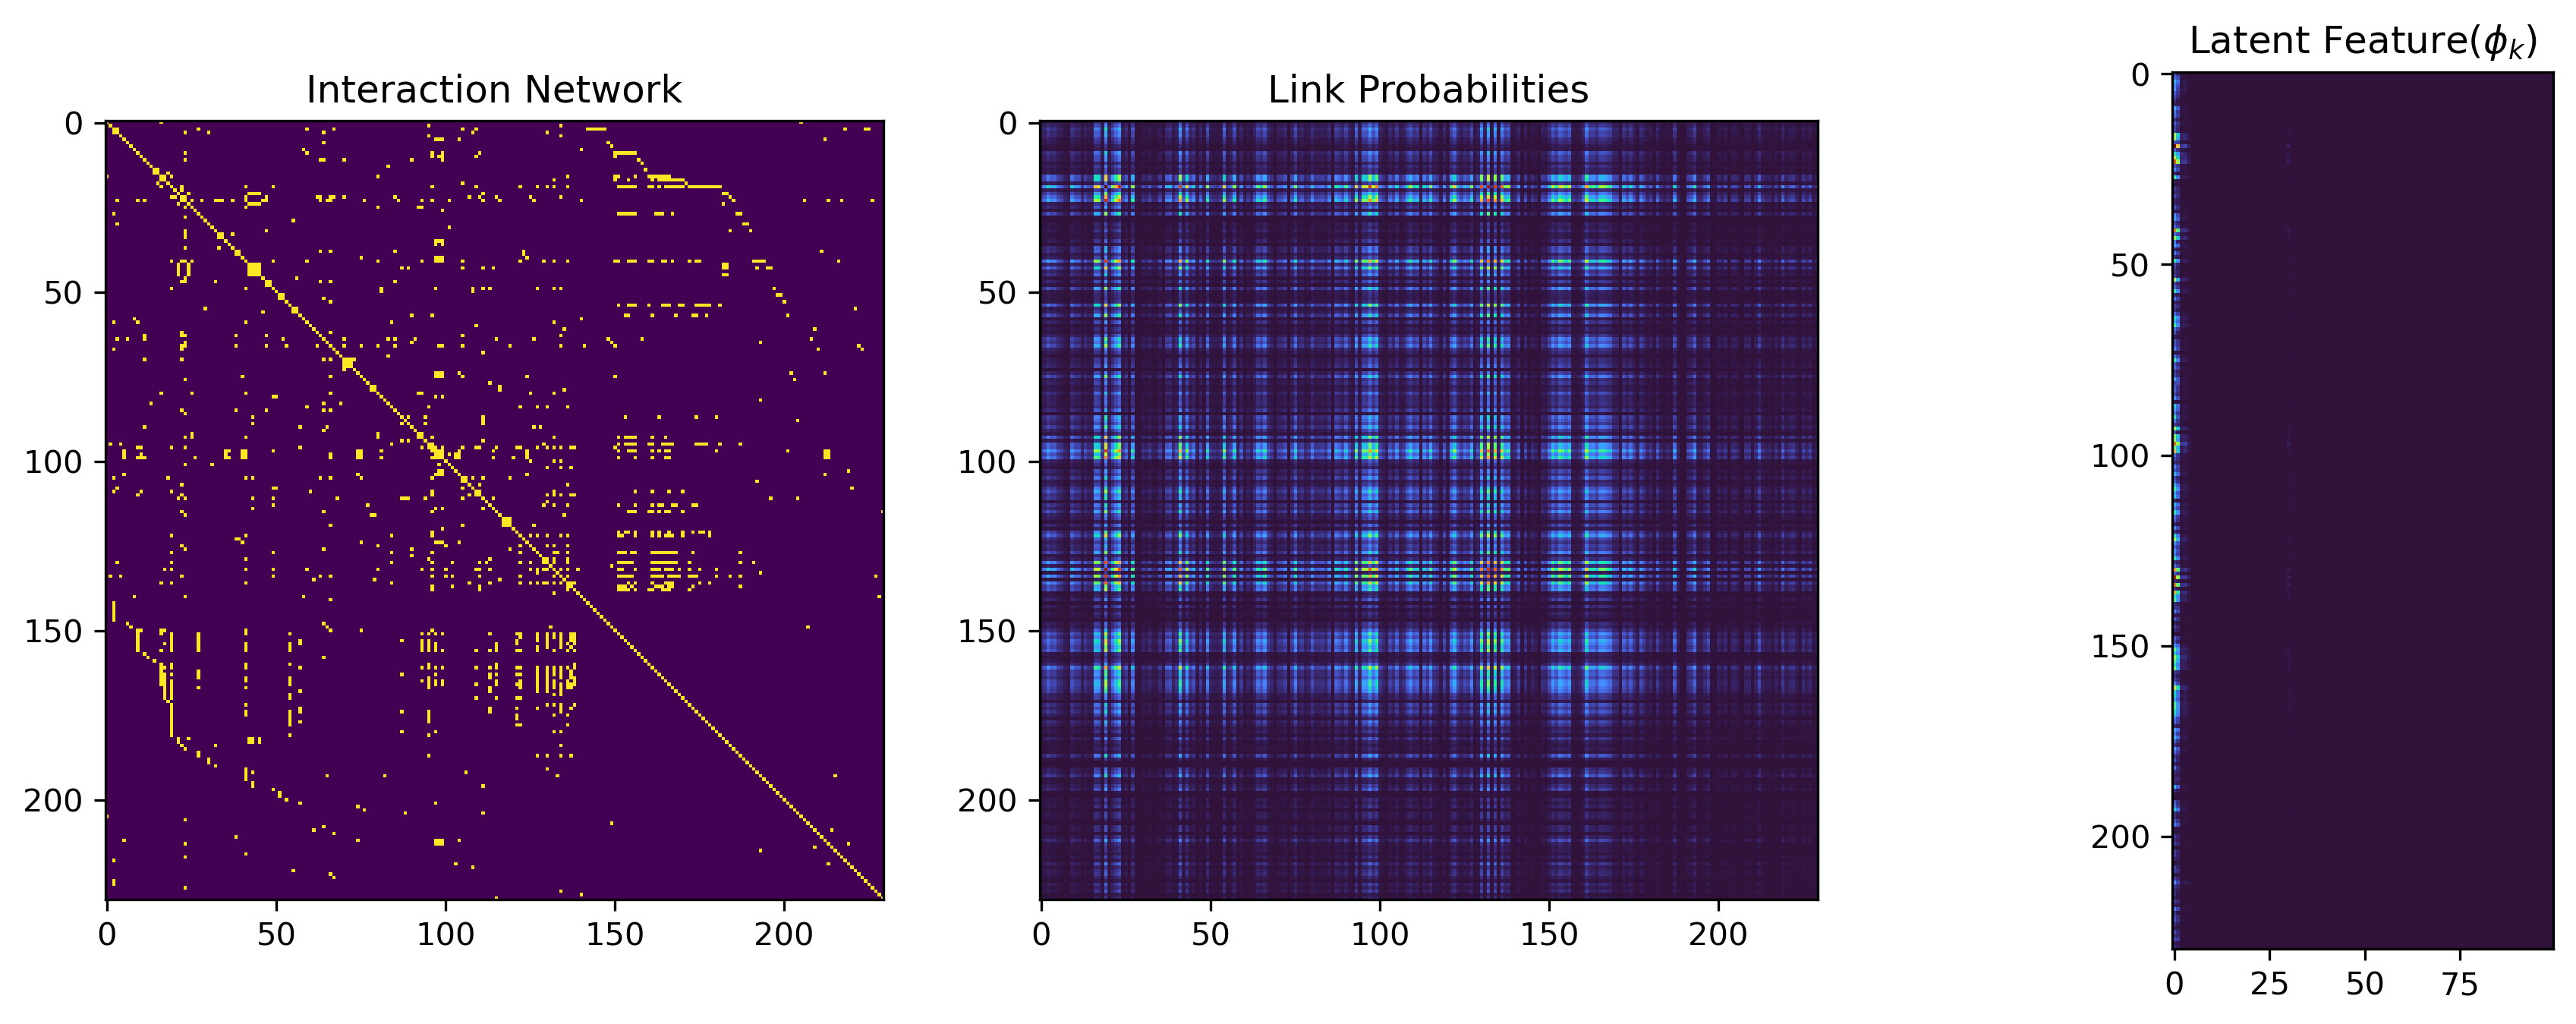

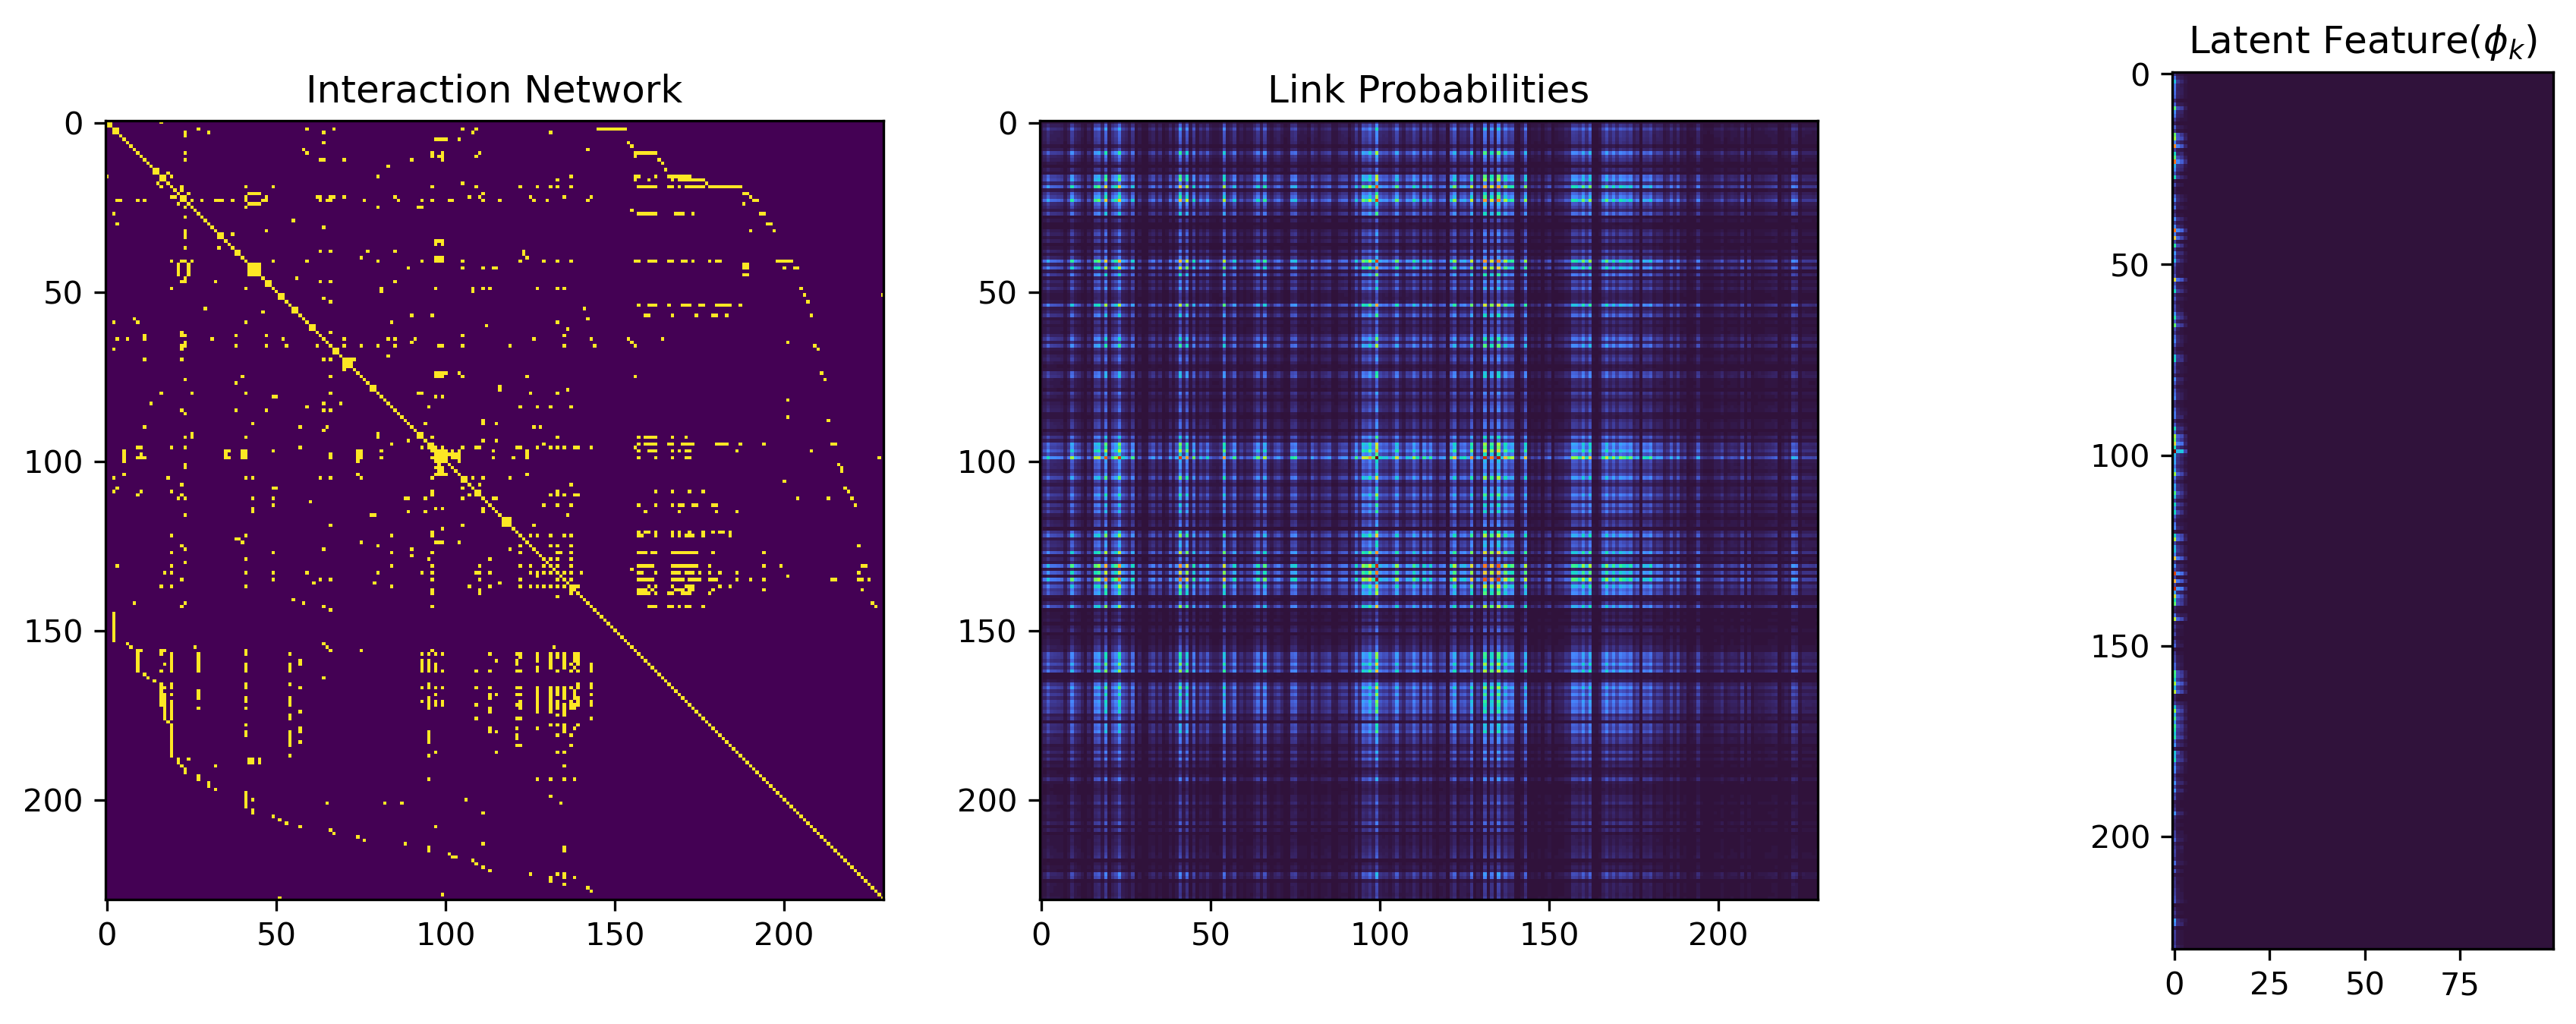

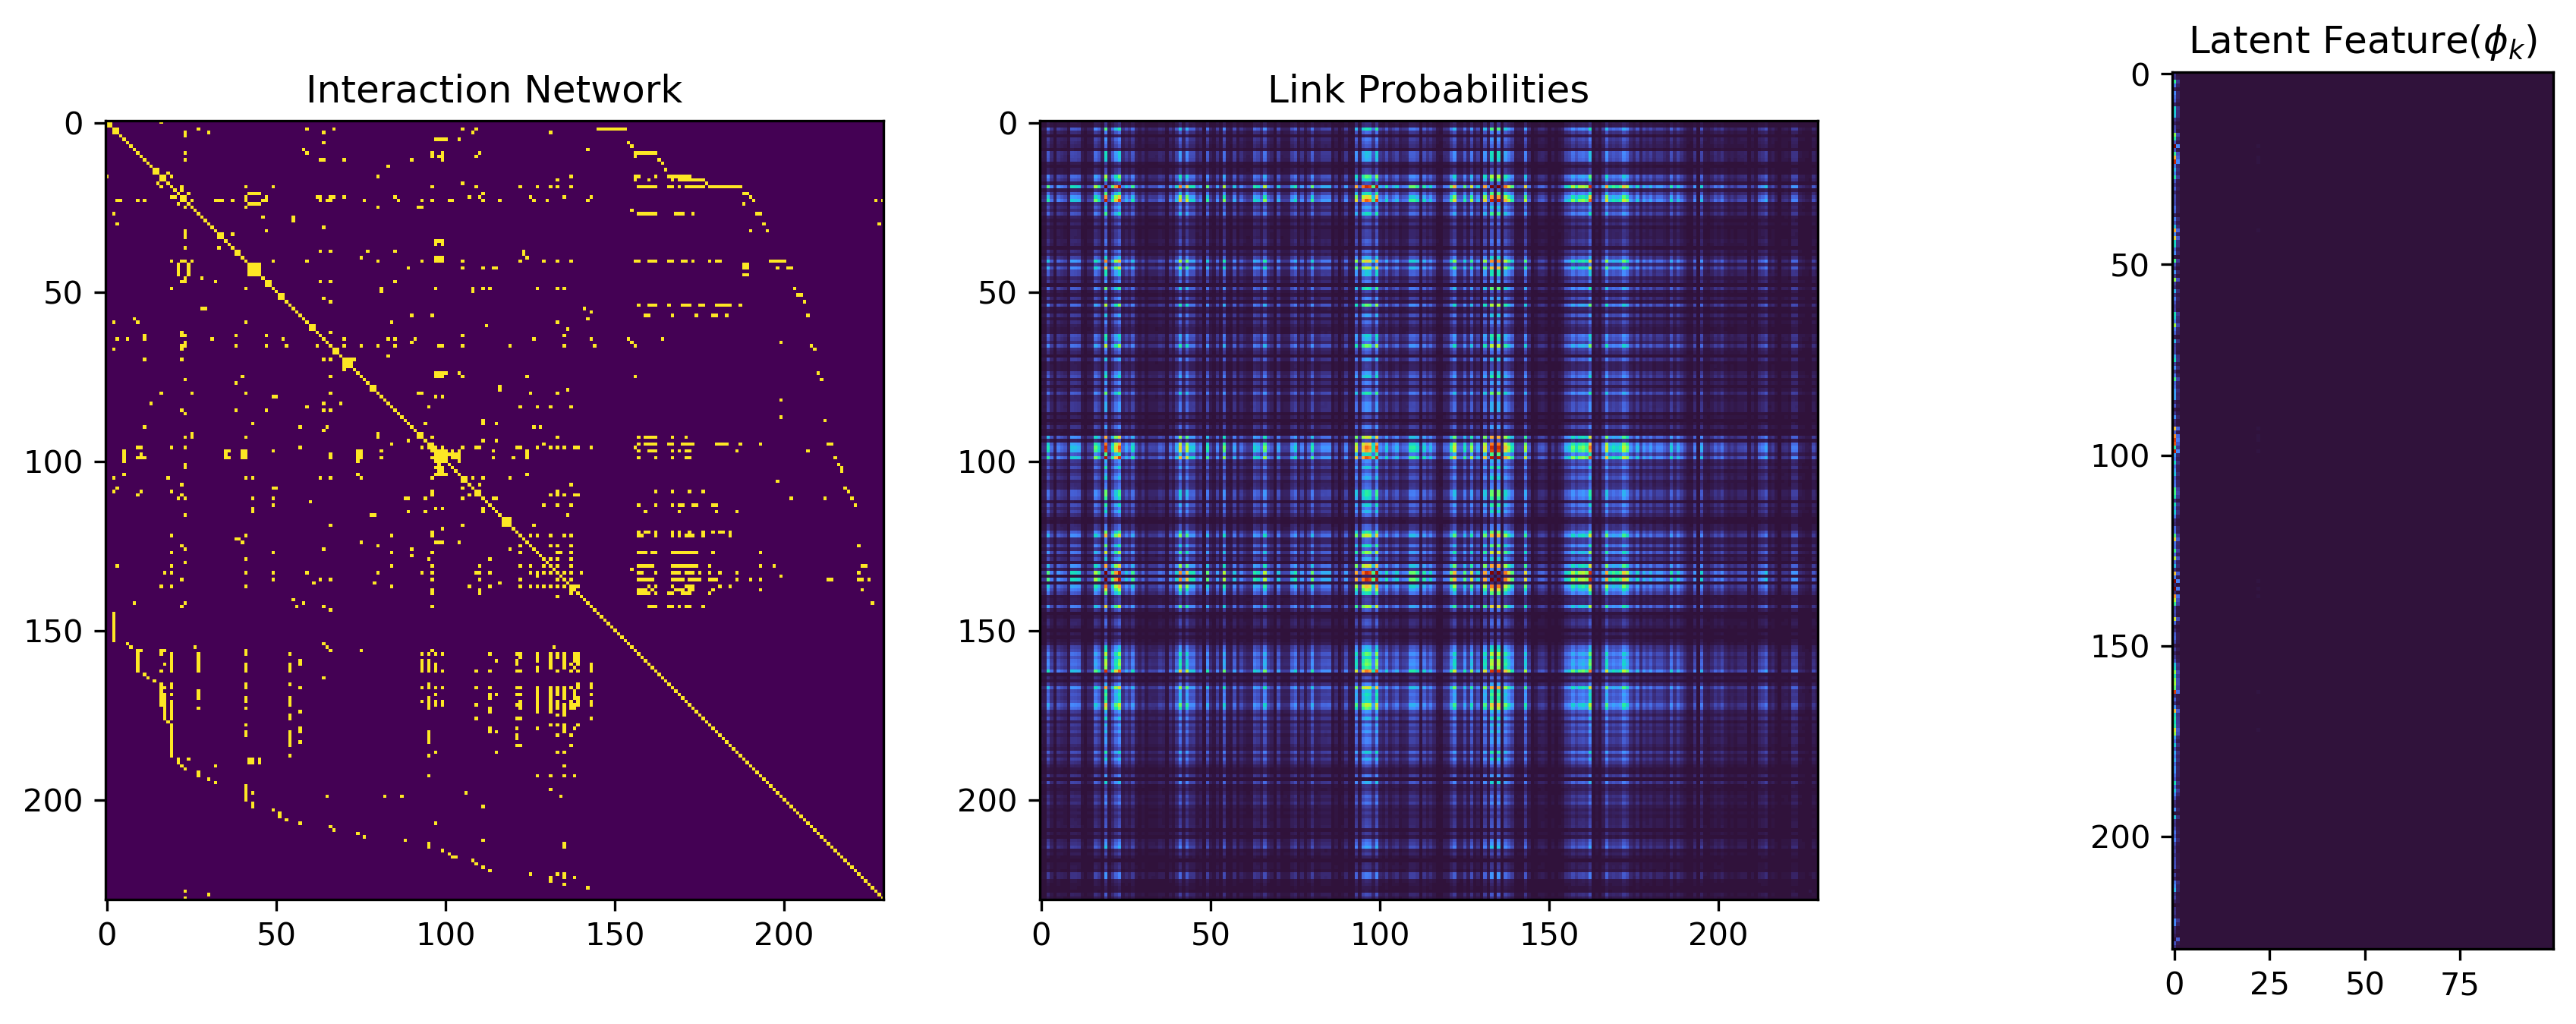

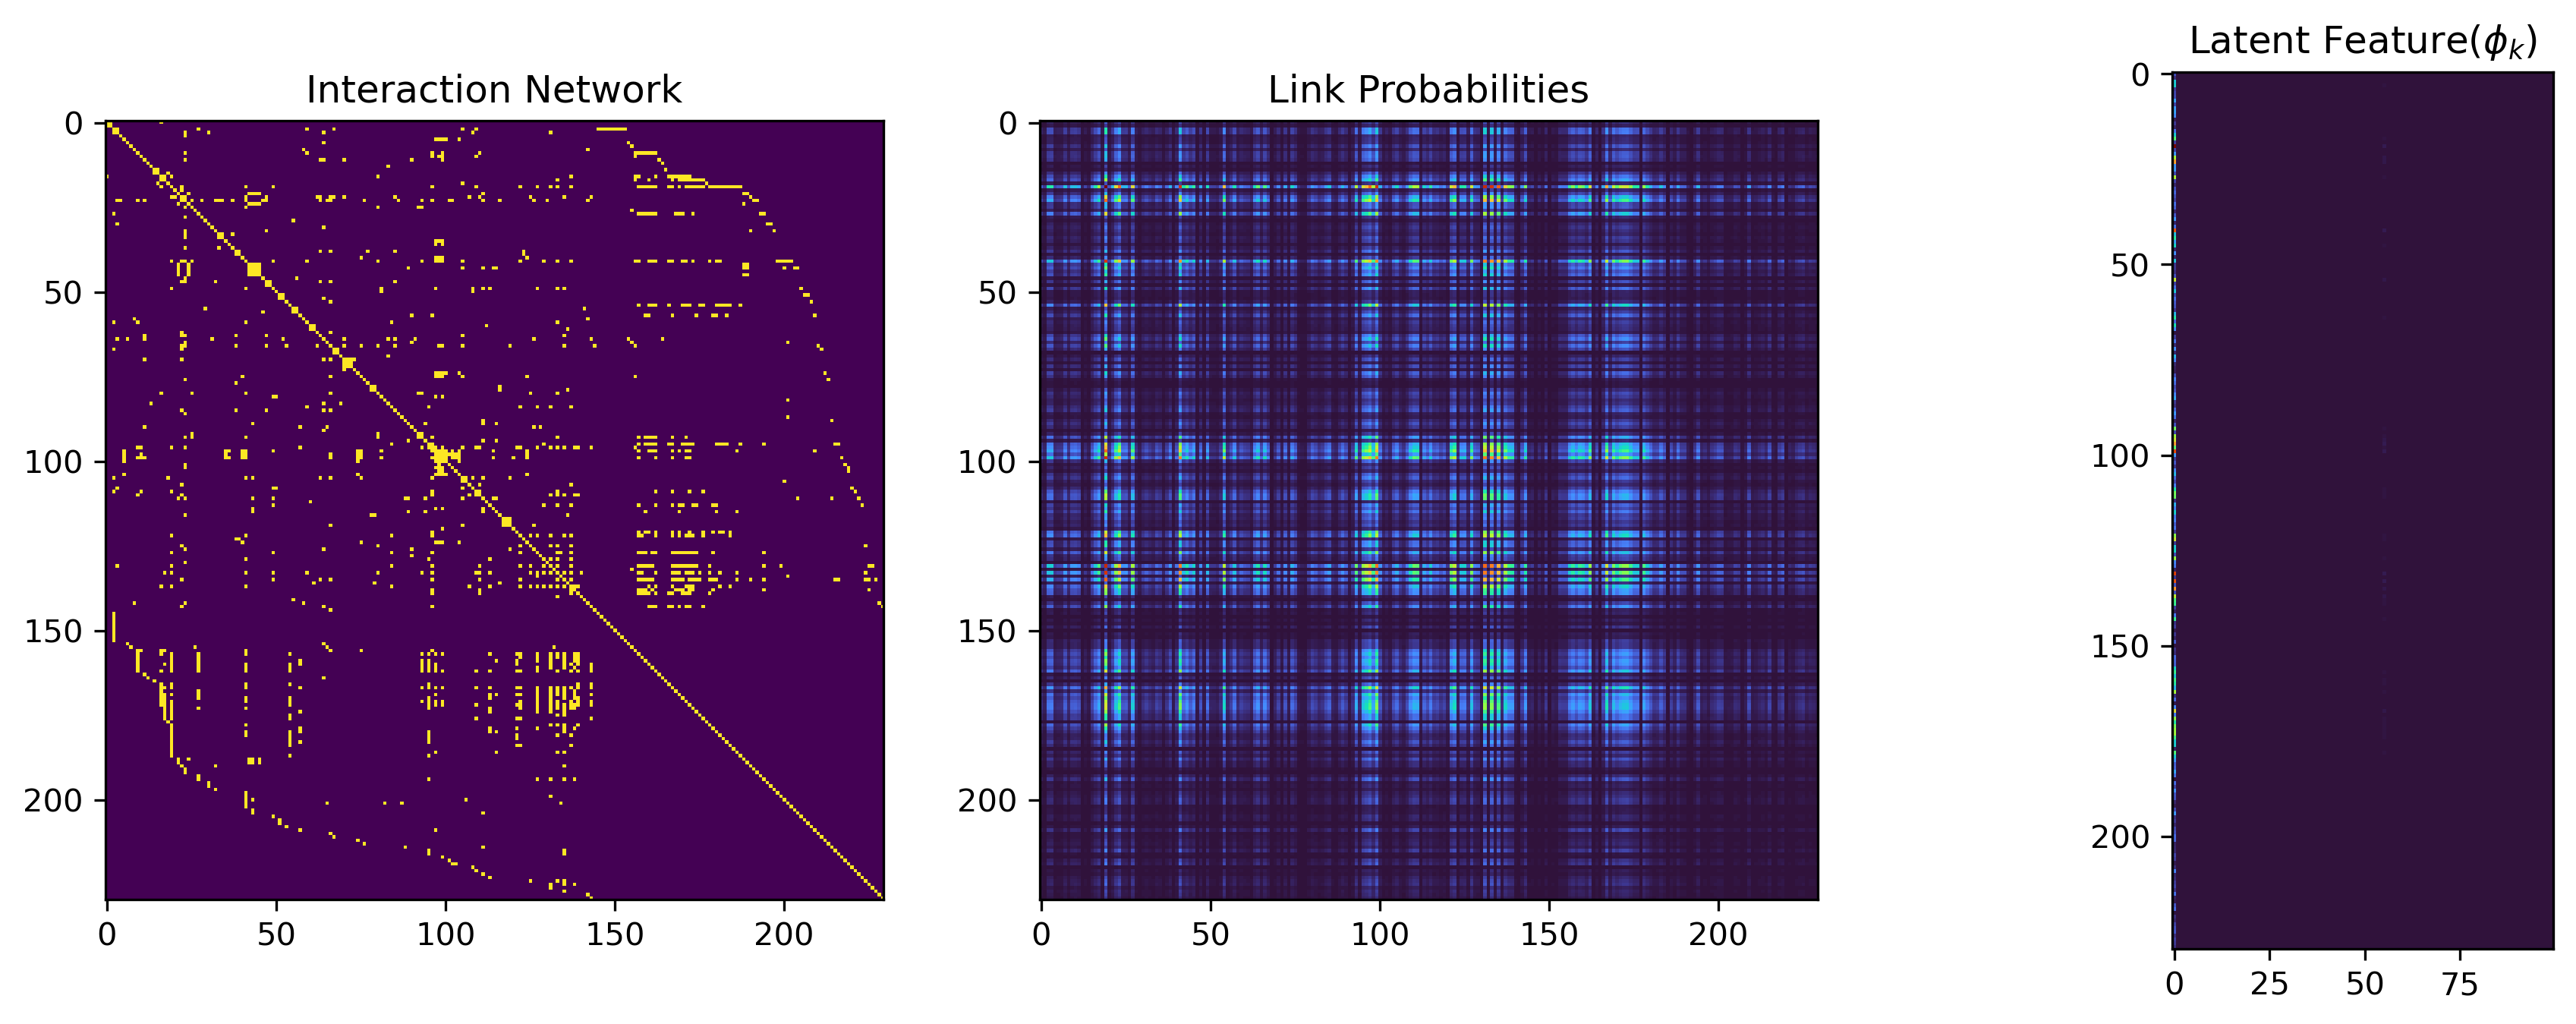

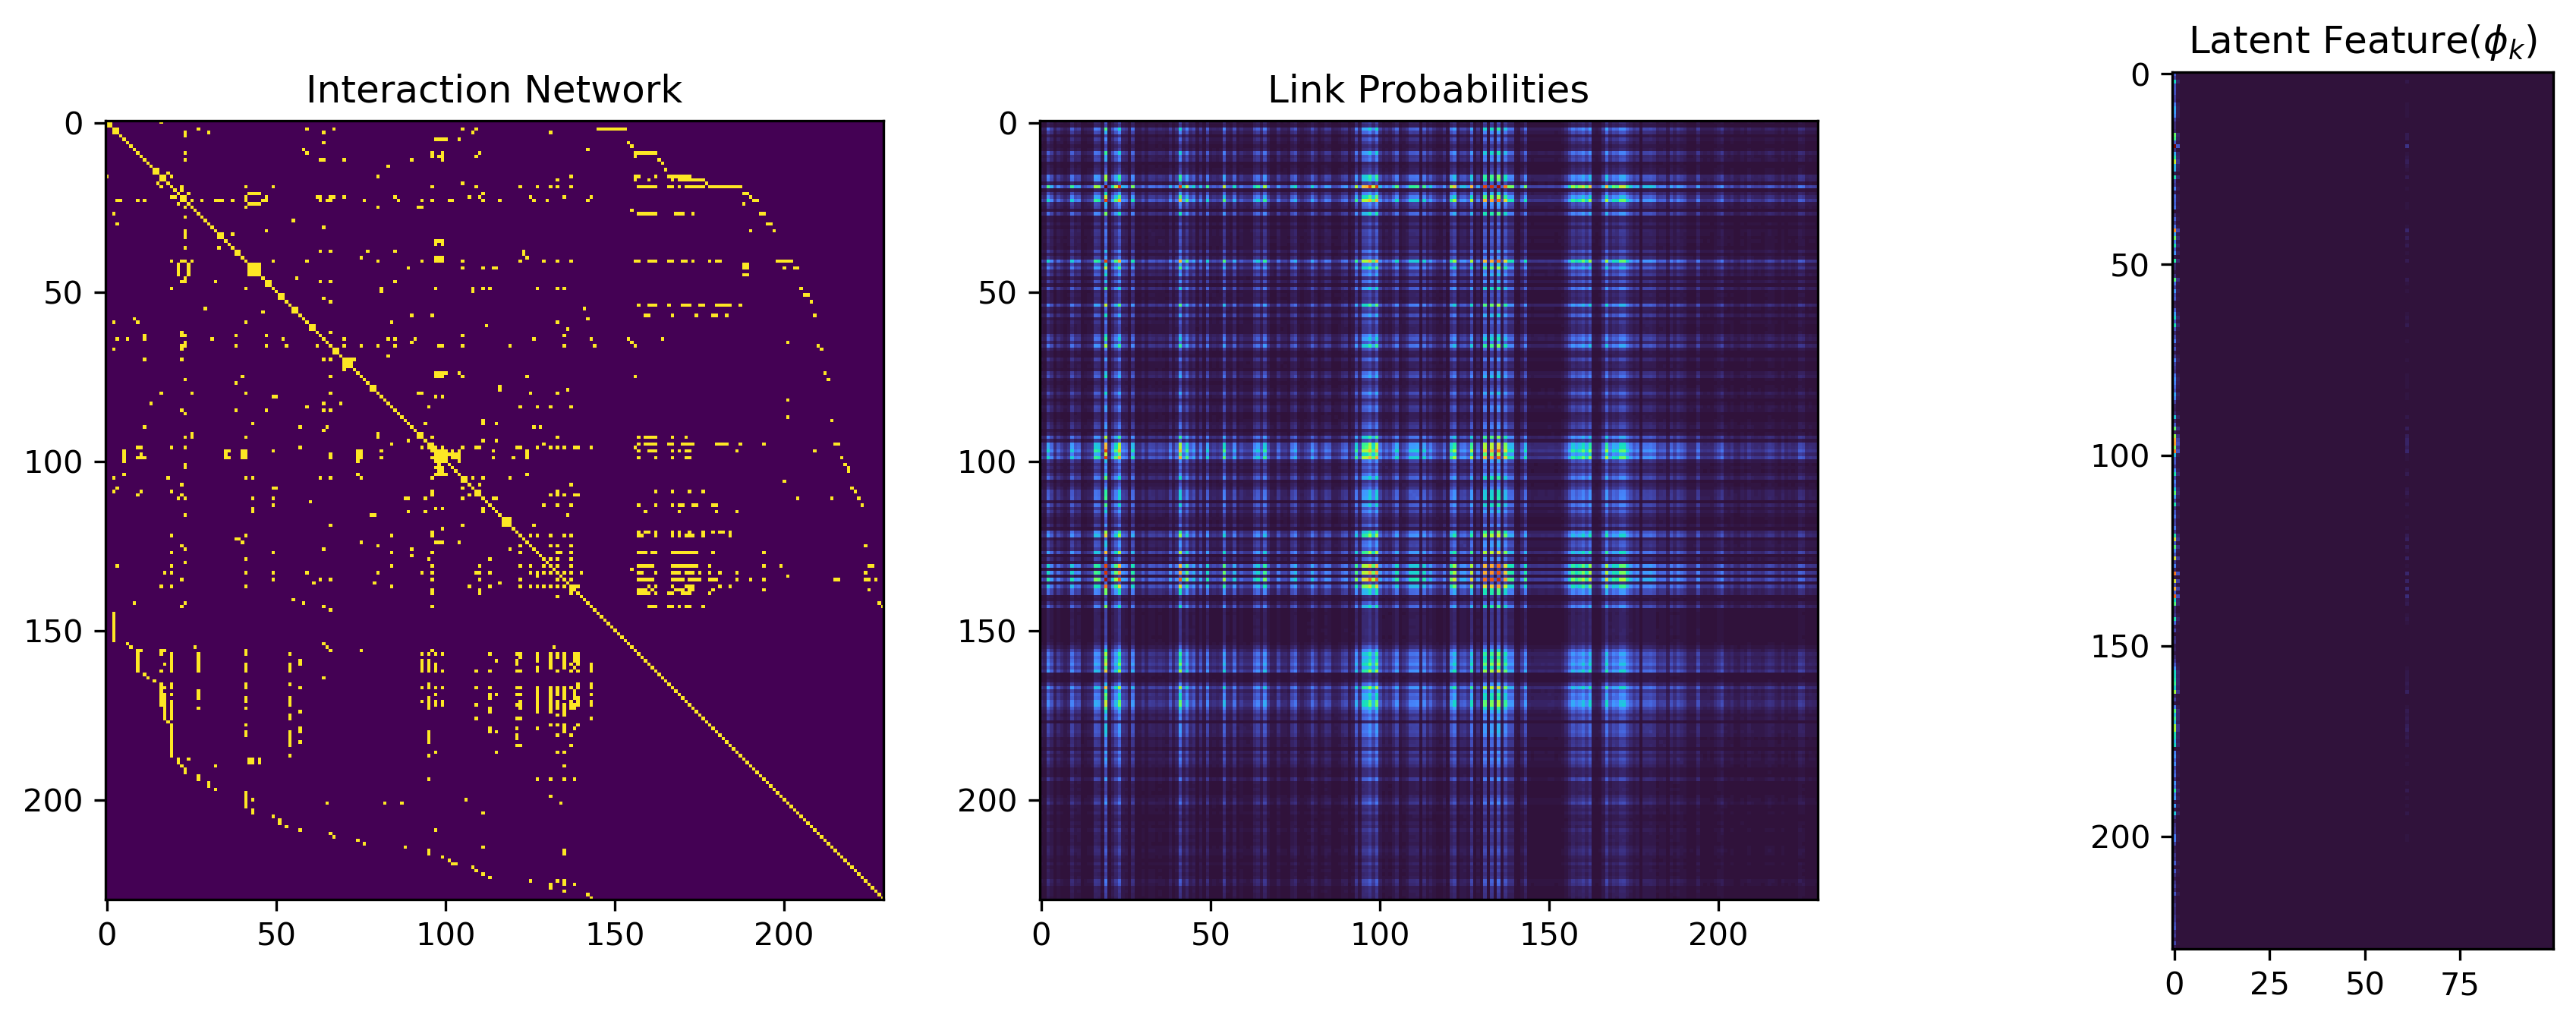

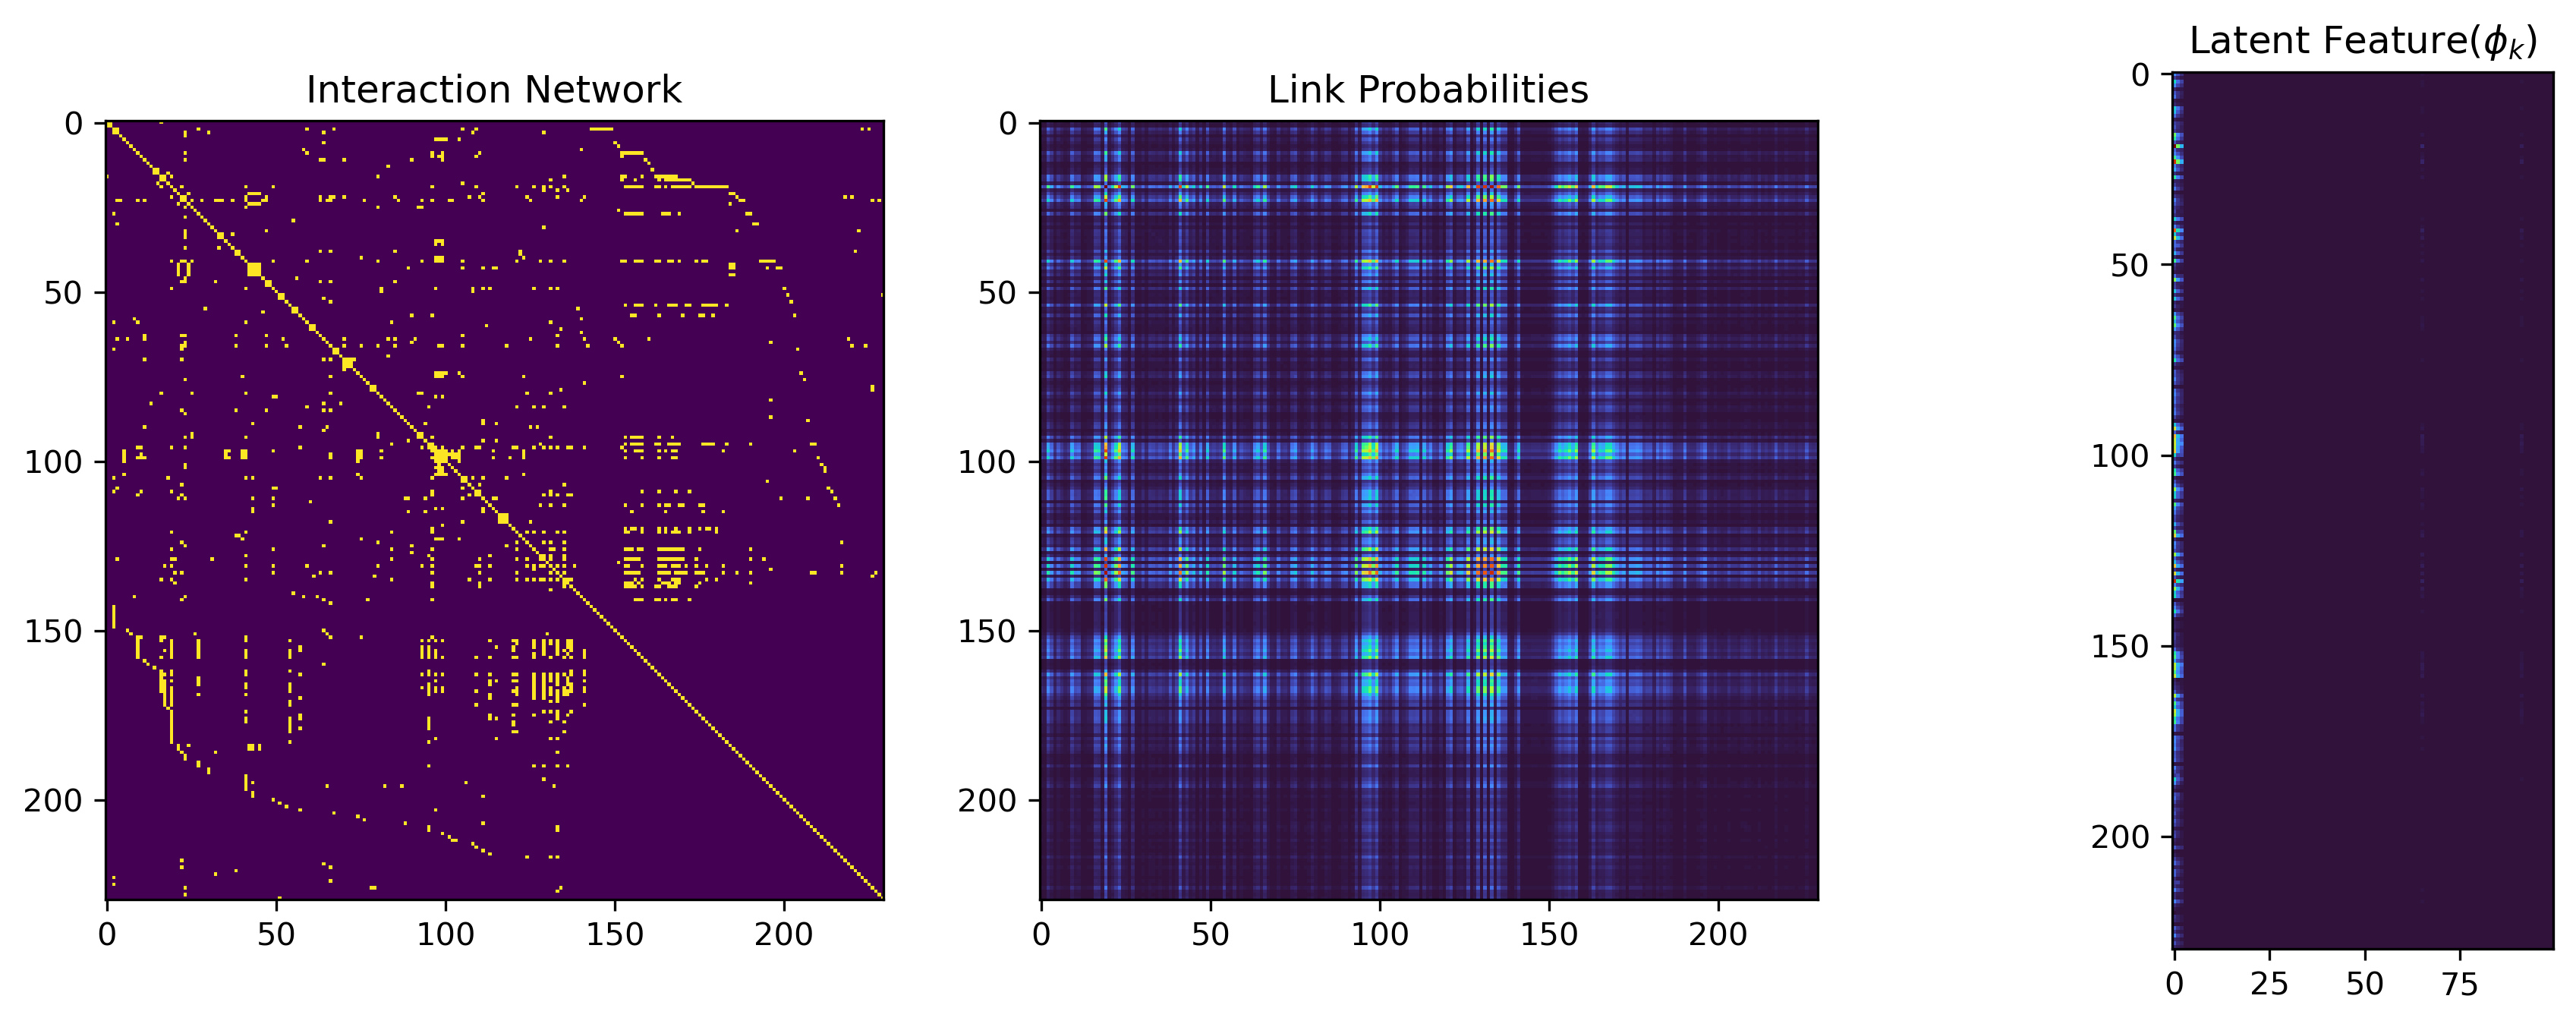

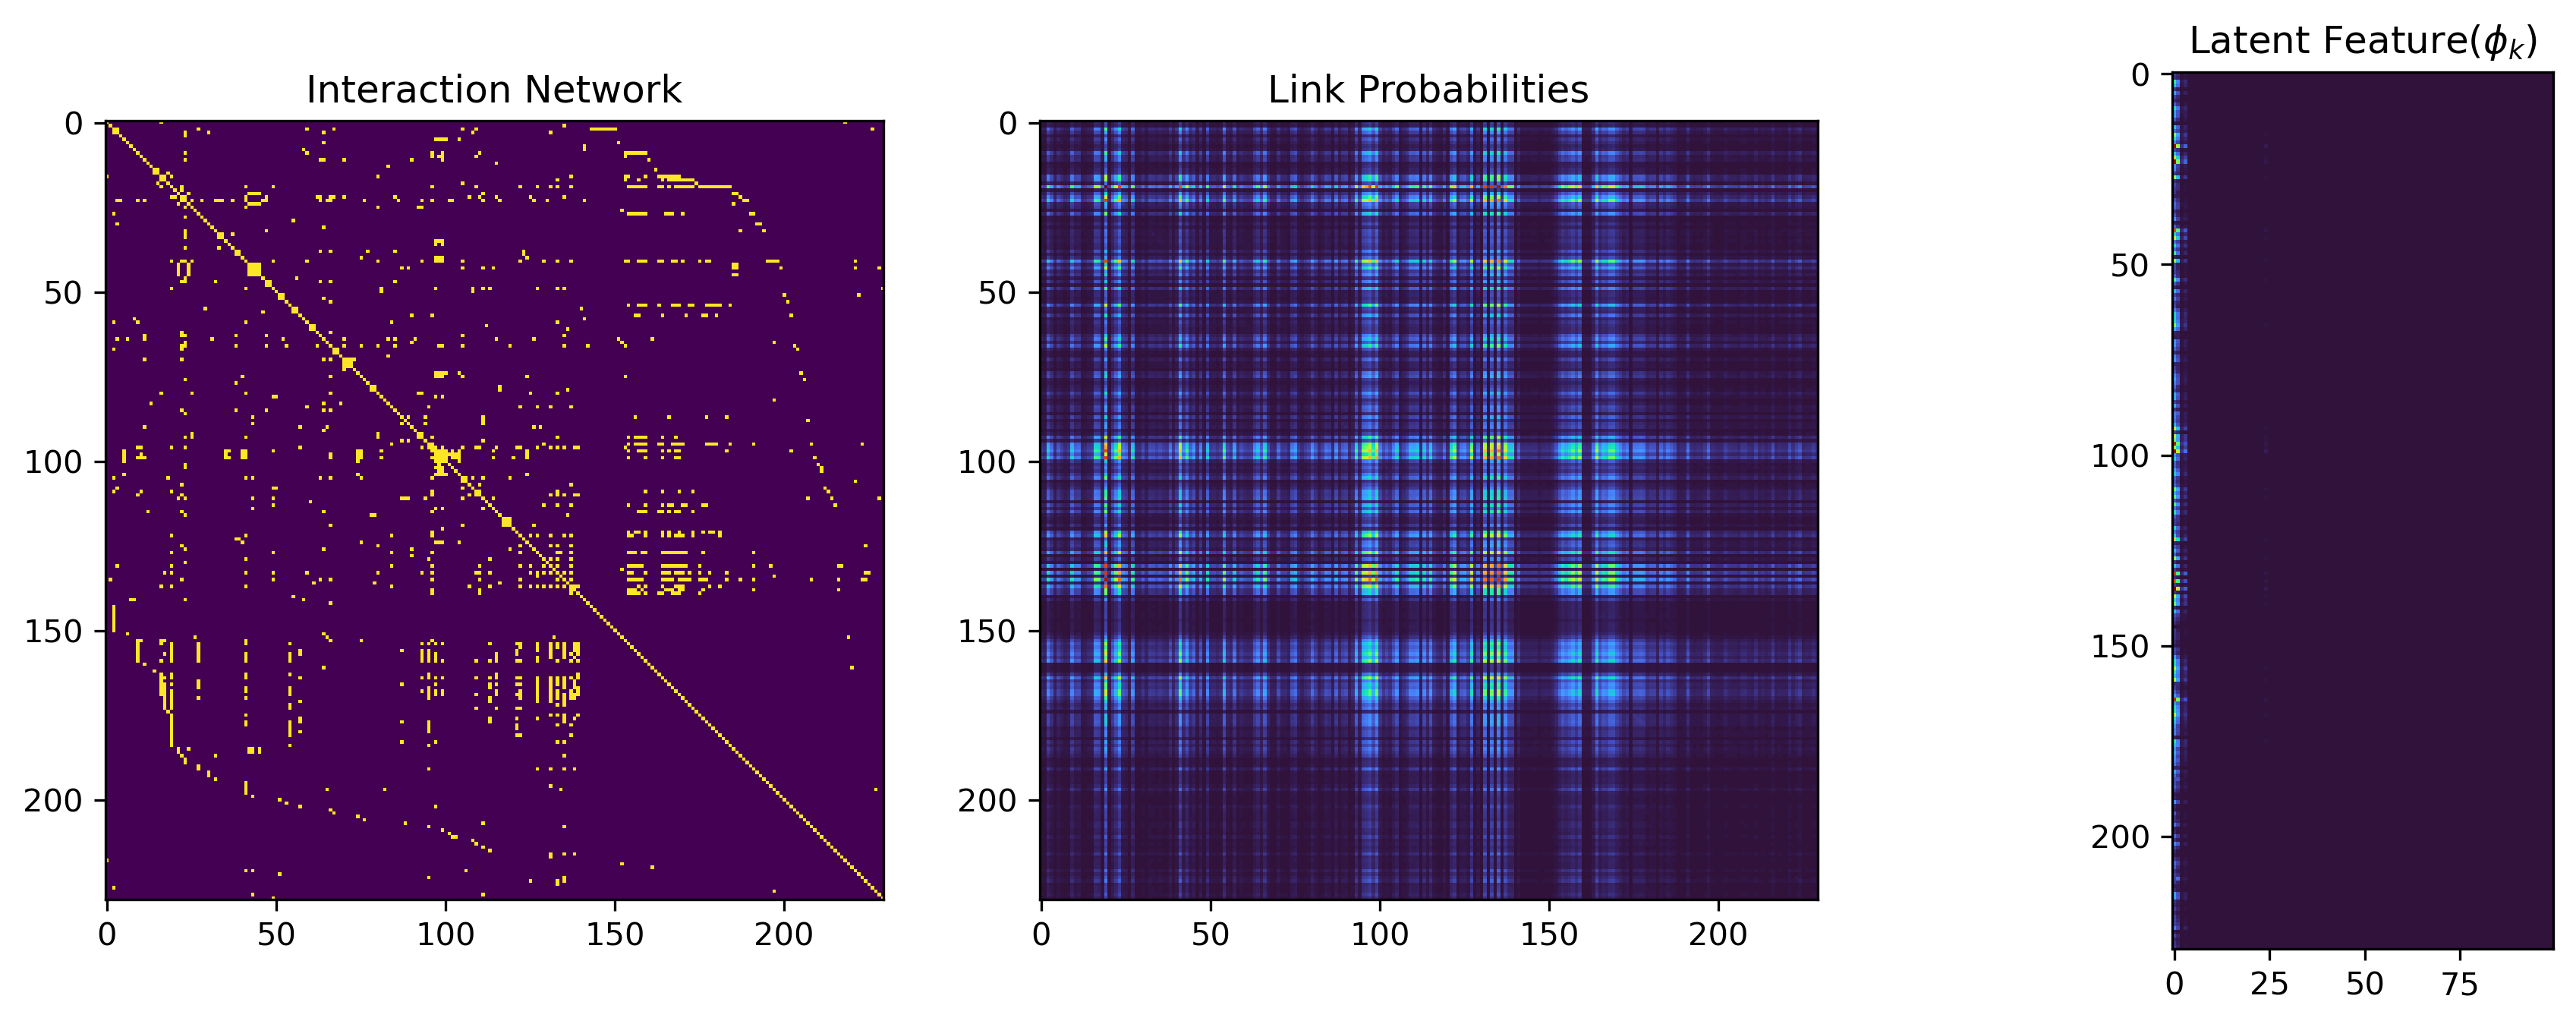

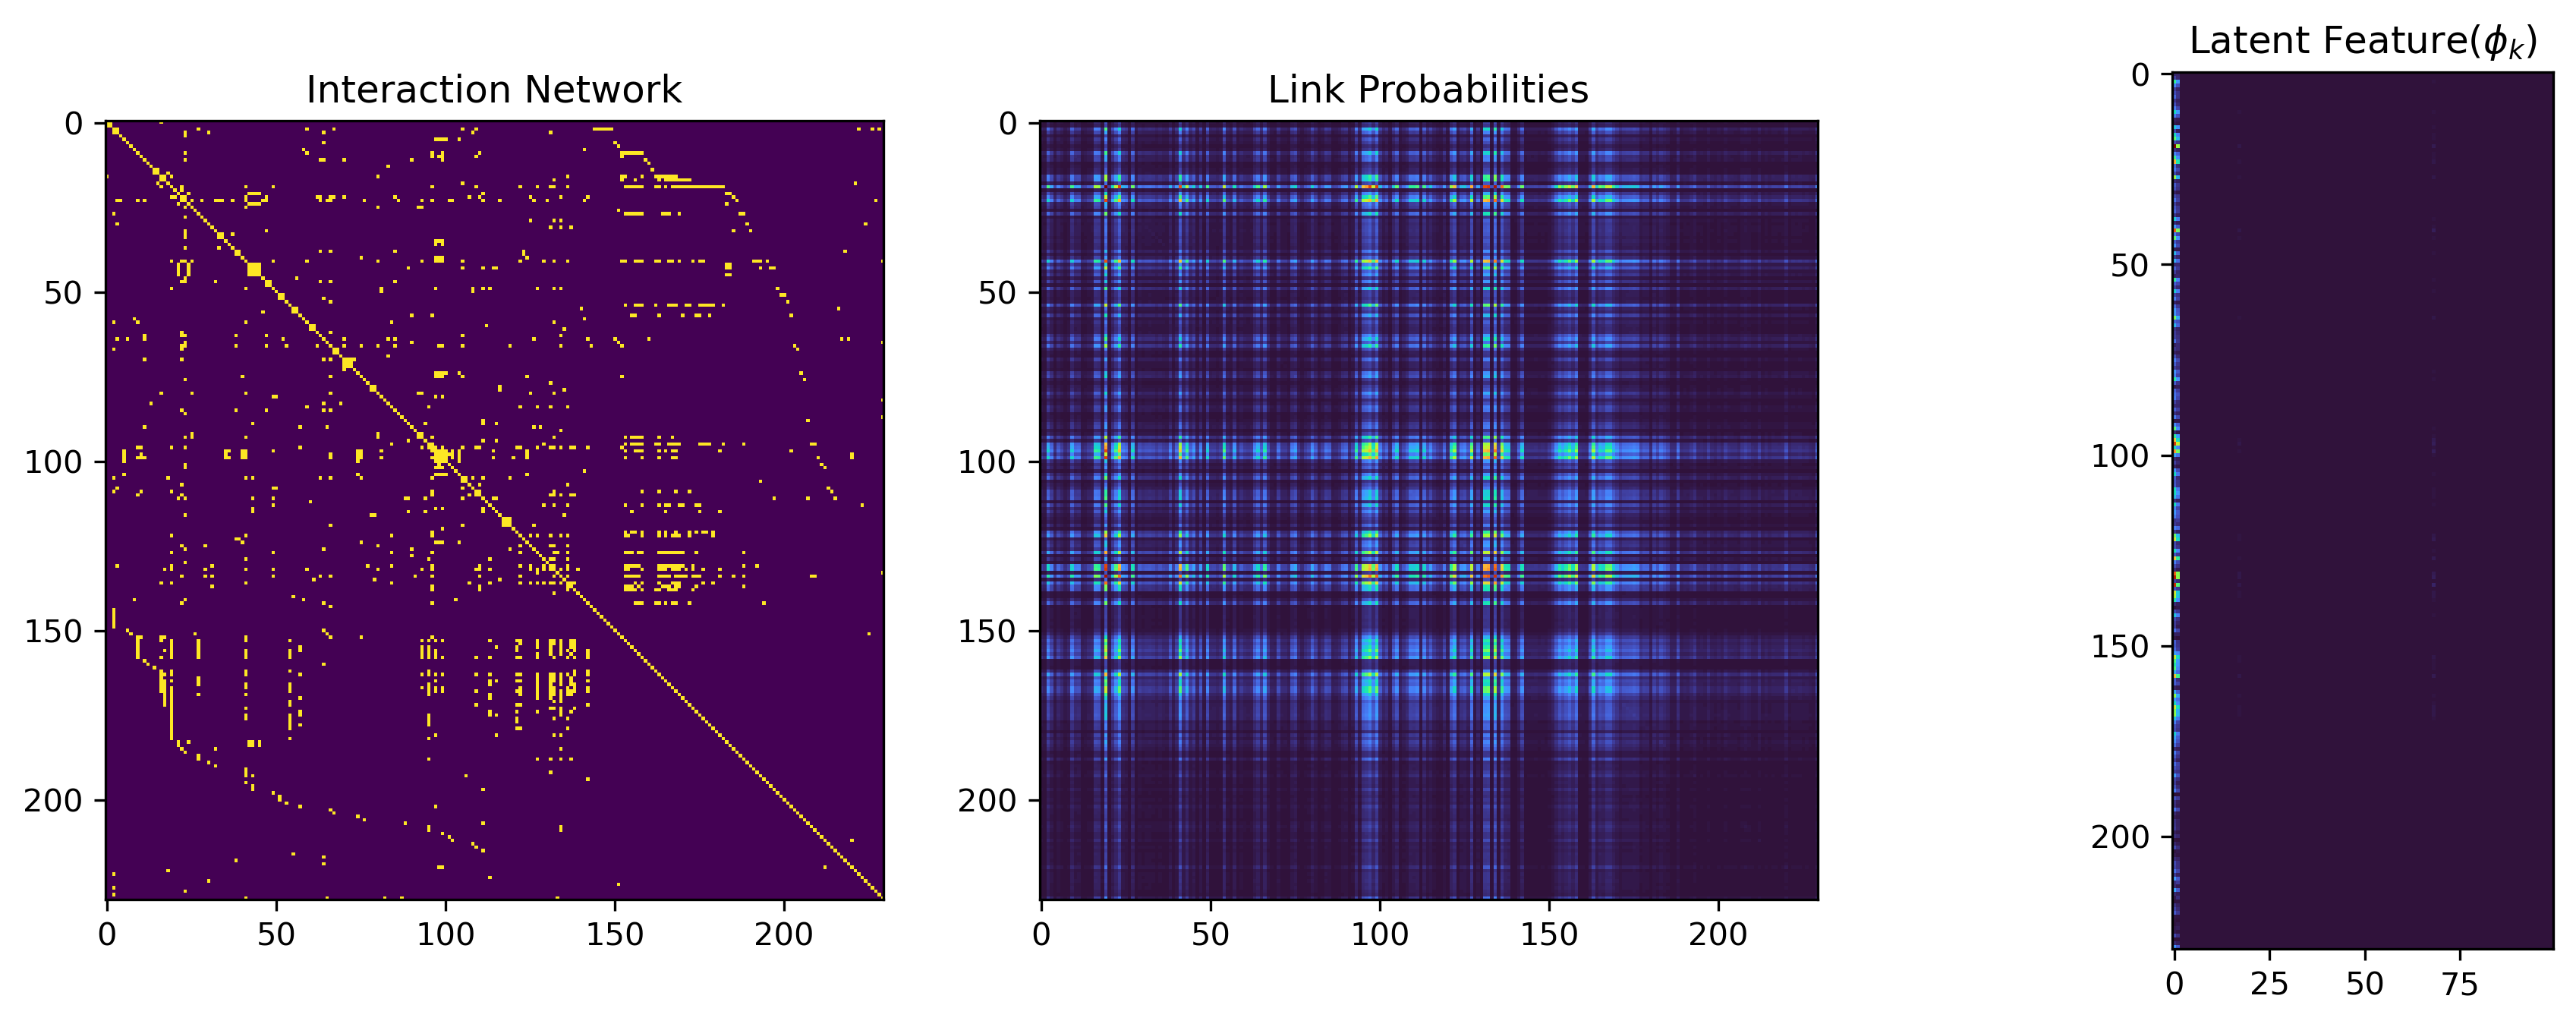

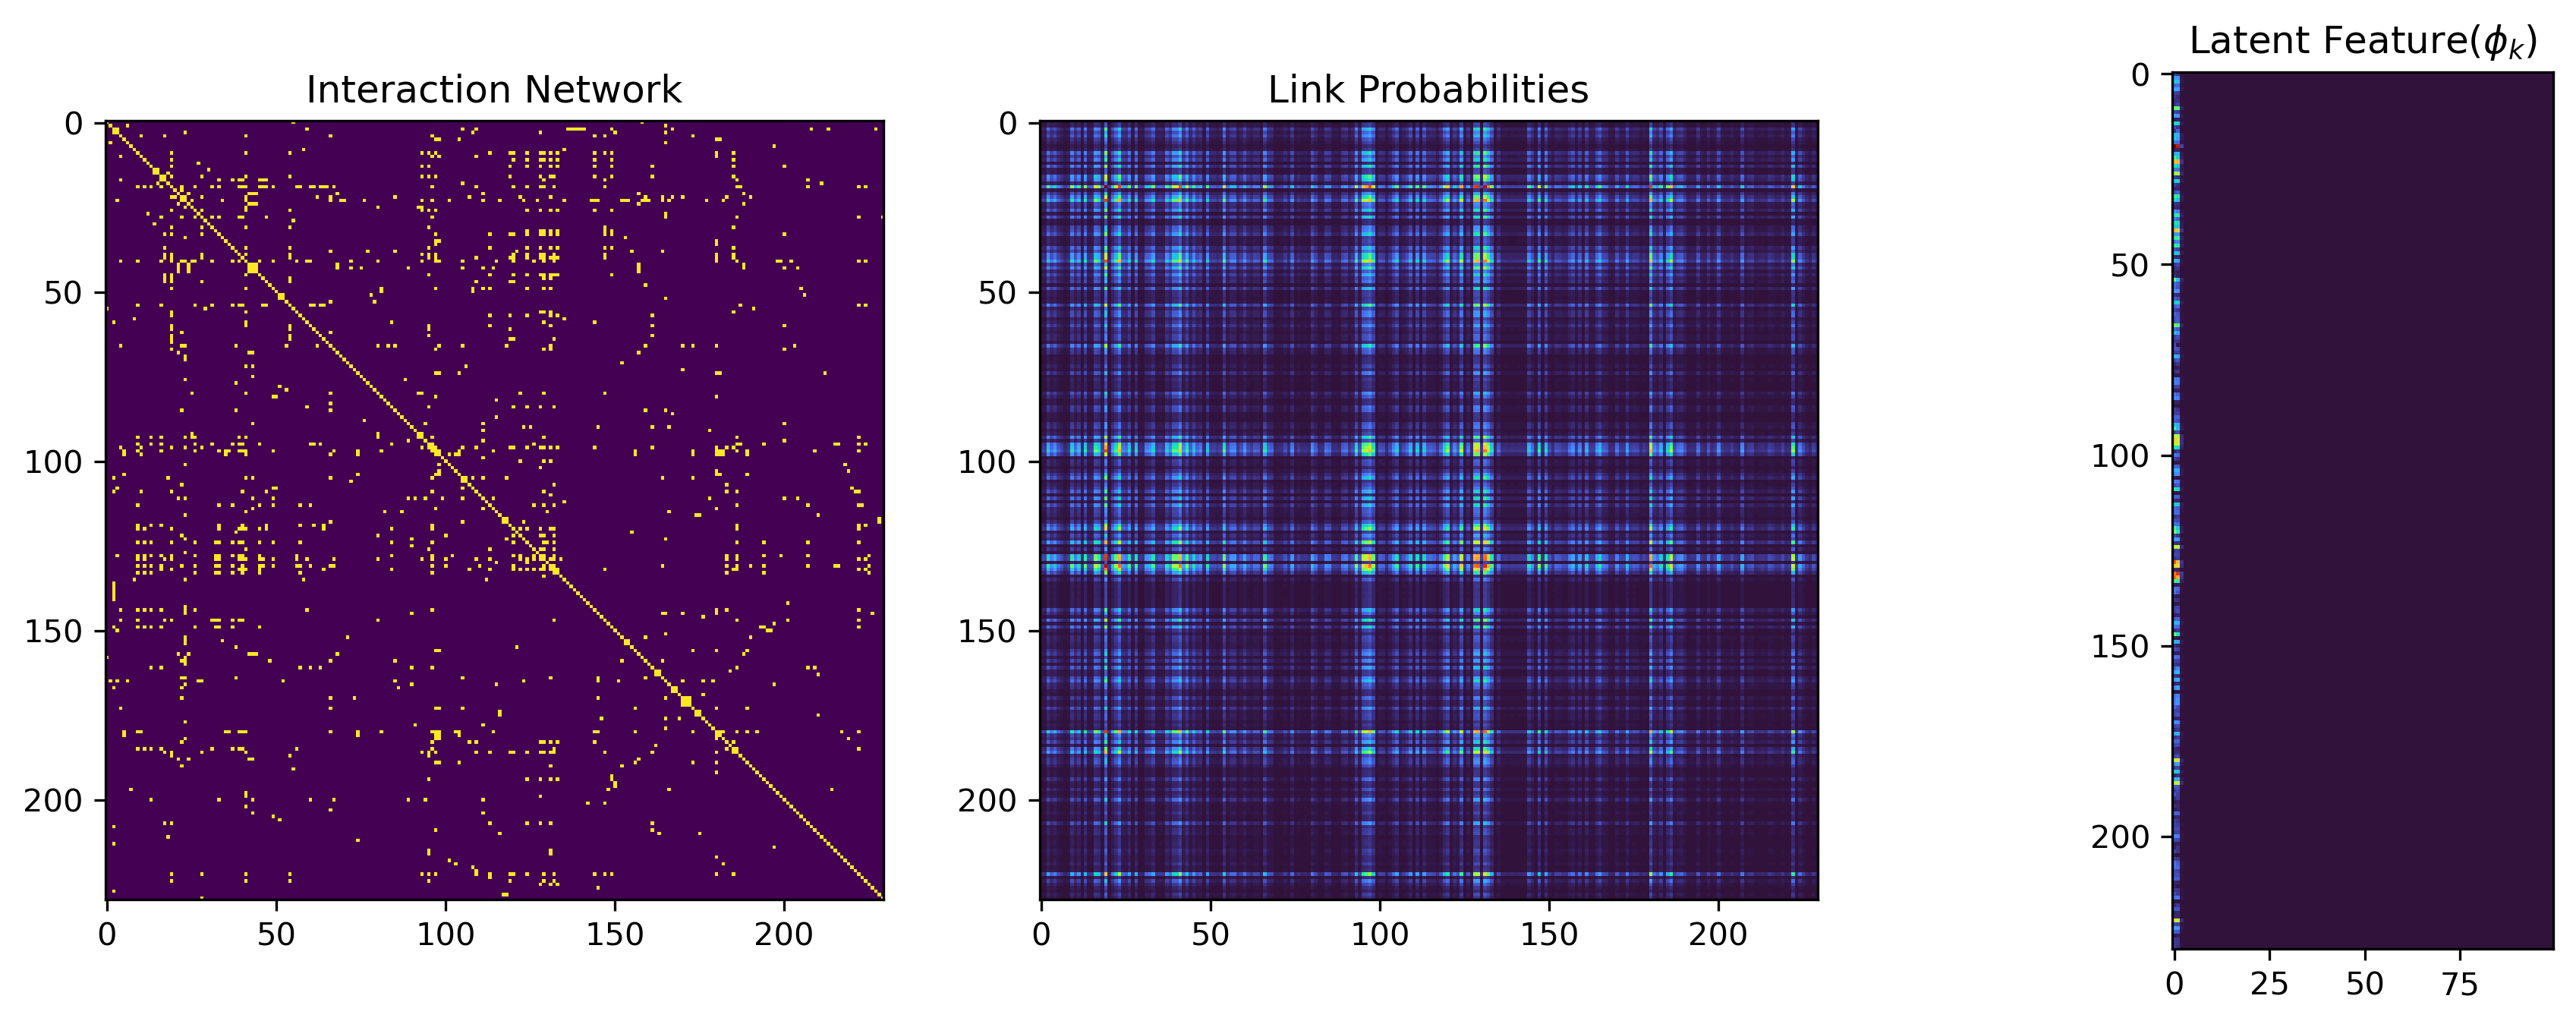

In [7]:
m_idx, n_idx = torch.nonzero(protein_data, as_tuple=True)
X = protein_data[m_idx, n_idx]
AA = protein_data + protein_data.T + torch.eye(len(protein_data))

model = GP_EPM(protein_config)
prob_sample = torch.zeros(protein_config.N, protein_config.N)

progress = tqdm(range(protein_config.burnin + protein_config.collection))
for i in progress:
    x_ik = model.do_inference(m_idx, n_idx, X)
    
    K_positive = len(torch.sum(x_ik, dim=-1).nonzero())
    
    prob = model.phi @ torch.diag(model.r) @ model.phi.T + eps
    prob = 1 - torch.exp(- prob)
    if i > protein_config.burnin:
        prob_sample = prob_sample + prob
        prob_ave = prob_sample / (i - protein_config.burnin)
    else:
        prob_ave = prob
        
    _, rdex = torch.sort(
        torch.sum(x_ik, dim=-1),
        descending=True
    )
    _, z = torch.max(x_ik[rdex], dim=0)
    _, Rank_dex = torch.sort(z)
    
    K_hardassignment = len(torch.unique(z))
    
    latent_feature = model.phi[Rank_dex][:, rdex] @ (torch.diag(model.r[rdex]) ** 0.5)
    latent_feature = torch.log(latent_feature + 9.99e-1)
    
    if (i+1)%300 == 0:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
        axs[0].set_title('Interaction Network')
        axs[0].imshow(AA[Rank_dex][:, Rank_dex])

        axs[1].set_title('Link Probabilities')
        axs[1].imshow(prob_ave[Rank_dex][:, Rank_dex], cmap='turbo')

        axs[2].set_title(r'Latent Feature($\phi_k$)')
        axs[2].imshow(latent_feature, cmap='turbo')
        
    progress.set_postfix({'K_plus': K_positive, 'K_hard': K_hardassignment, 'gamma0': model.gamma_0.item()})